# **Group Assignment 2: Predicting Default Risk on Peer-to-Peer Lending Platform**

**Case Background**

Peer-to-peer (P2P) lending is a method of debt financing that enables individuals to borrow and lend money without the use of an official financial institution as an intermediary. P2P lending removes the middleman from the process, but it also involves more time, effort, and risk than the general route of going through a traditional financial institution. We have information about different loans in the past. We want to use this information to predict the default risk and the returns associated with different types of loans, and recommend a financial decision on which types of loans to invest.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm #library for statistics analysis#
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm
!pip install ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from statsmodels.iolib.summary2 import summary_col


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
  

# 1. Data Pre-processing

In [ ]:
file_path = '../data/cleaned_p2p_2007_to_2018Q4.csv'

df = pd.read_csv(file_path)

num_observations = df.shape[0]
num_variables = df.shape[1]

print(f"Original number of observations: {num_observations}")
print(f"Original number of variables: {num_variables}")

df_original = df.copy(deep=True)

df.head()

Mounted at /content/drive


<ipython-input-2-048bc59bfe3f>:7: DtypeWarning: Columns (45,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Original number of observations: 1044489
Original number of variables: 114


id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  66624733      18000        18000          18000.0   60 months     19.48   
1  67849662       4225         4225           4225.0   36 months     14.85   
2  67715283      16000        16000          16000.0   36 months     12.88   
3  68341789      24250        24250          24250.0   60 months     24.24   
4  68415473      25000        25000          25000.0   60 months     13.99   

   installment grade sub_grade              emp_title  ... percent_bc_gt_75  \
0       471.70     E        E2       Software Manager  ...             14.3   
1       146.16     C        C5               mechanic  ...              0.0   
2       538.18     C        C2  Owner, Fee Appraiser   ...              0.0   
3       701.01     F        F3        hvac technician  ...             63.6   
4       581.58     C        C4    Executive Assistant  ...              0.0   

  pub_rec_bankruptcies  tax_liens tot_hi_cred_lim total_bal_ex_mort  \
0                    1          0           65819             36247   
1                    0          0           21822              4888   
2                    0          1           80999             39781   
3                    0          0          344960             38475   
4                    0          0          389002             89978   

  total_bc_limit total_il_high_credit_limit hardship_flag disbursement_method  \
0          10300                      31319             N                Cash   
1           2600                      17522             N                Cash   
2           4700                      71499             N                Cash   
3          29100                      18300             N                Cash   
4          72600                      81802             N                Cash   

  debt_settlement_flag  
0                    N  
1                    N  
2                    N  
3                    N  
4                    N  

[5 rows x 114 columns]

# Understand the Data

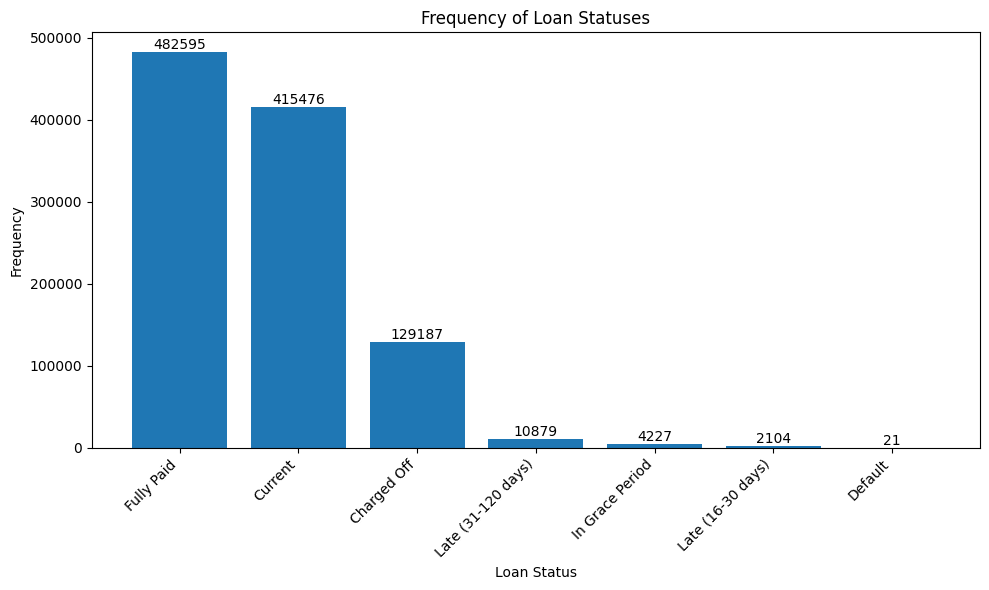

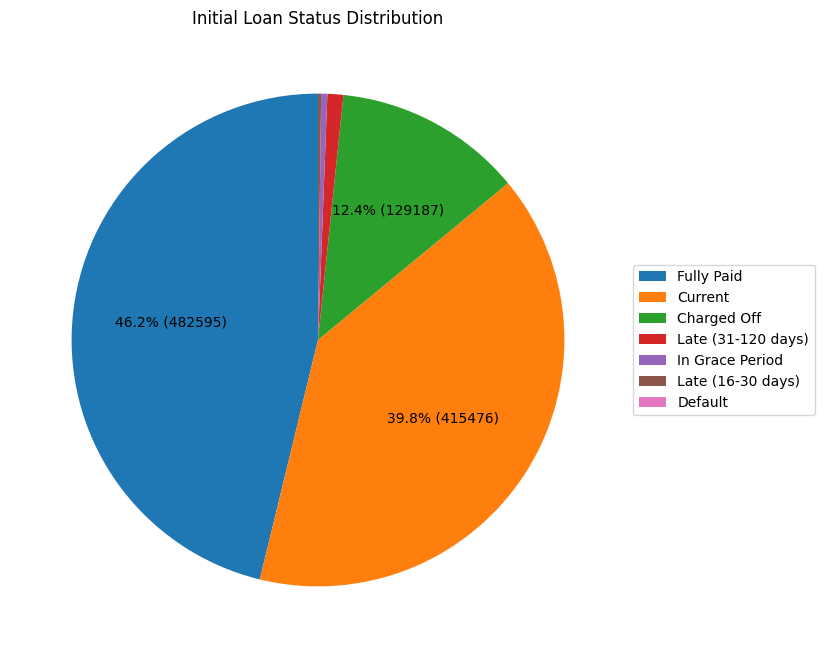

In [ ]:
# Calculate initial loan status counts
initial_loan_status_counts = df_original['loan_status'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(initial_loan_status_counts.index, initial_loan_status_counts.values)

# Add frequency labels on top of each bar
for bar, frequency in zip(bars, initial_loan_status_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), frequency,
             ha='center', va='bottom')

plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Frequency of Loan Statuses')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 8))

# Define a function to selectively display labels
def my_autopct(pct):
    # Set a threshold for displaying labels (e.g., show for percentages >= 5%)
    threshold = 5
    return f'{pct:.1f}% ({pct * sum(initial_loan_status_counts) / 100:.0f})' if pct >= threshold else ''


plt.pie(initial_loan_status_counts,
        labels=None,  # Remove all slice labels
        autopct=my_autopct,  # Use the custom autopct function
        startangle=90)

plt.title('Initial Loan Status Distribution')

# Add a legend outside the pie chart for all statuses
plt.legend(initial_loan_status_counts.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [ ]:
# Keep only the specified loan statuses
loan_status_keep = ['Charged Off', 'Default', 'Fully Paid']
df = df[df['loan_status'].isin(loan_status_keep)]

# Check the number of observations remaining
print(f"\nNumber of observations after filtering: {df.shape[0]}")

# Create the dummy variable
df['loan_default_dummy'] = np.where(df['loan_status'].isin(['Charged Off', 'Default']), 1, 0)

# Calculate the value counts for the new 'loan_default_dummy' column
default_counts = df['loan_default_dummy'].value_counts()

# Display the first few rows to verify the new column
df.head()



Number of observations after filtering: 611803


id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  66624733      18000        18000          18000.0   60 months     19.48   
1  67849662       4225         4225           4225.0   36 months     14.85   
2  67715283      16000        16000          16000.0   36 months     12.88   
3  68341789      24250        24250          24250.0   60 months     24.24   
4  68415473      25000        25000          25000.0   60 months     13.99   

   installment grade sub_grade              emp_title  ...  \
0       471.70     E        E2       Software Manager  ...   
1       146.16     C        C5               mechanic  ...   
2       538.18     C        C2  Owner, Fee Appraiser   ...   
3       701.01     F        F3        hvac technician  ...   
4       581.58     C        C4    Executive Assistant  ...   

  pub_rec_bankruptcies tax_liens  tot_hi_cred_lim total_bal_ex_mort  \
0                    1         0            65819             36247   
1                    0         0            21822              4888   
2                    0         1            80999             39781   
3                    0         0           344960             38475   
4                    0         0           389002             89978   

  total_bc_limit total_il_high_credit_limit hardship_flag disbursement_method  \
0          10300                      31319             N                Cash   
1           2600                      17522             N                Cash   
2           4700                      71499             N                Cash   
3          29100                      18300             N                Cash   
4          72600                      81802             N                Cash   

  debt_settlement_flag loan_default_dummy  
0                    N                  1  
1                    N                  1  
2                    N                  1  
3                    N                  1  
4                    N                  1  

[5 rows x 115 columns]

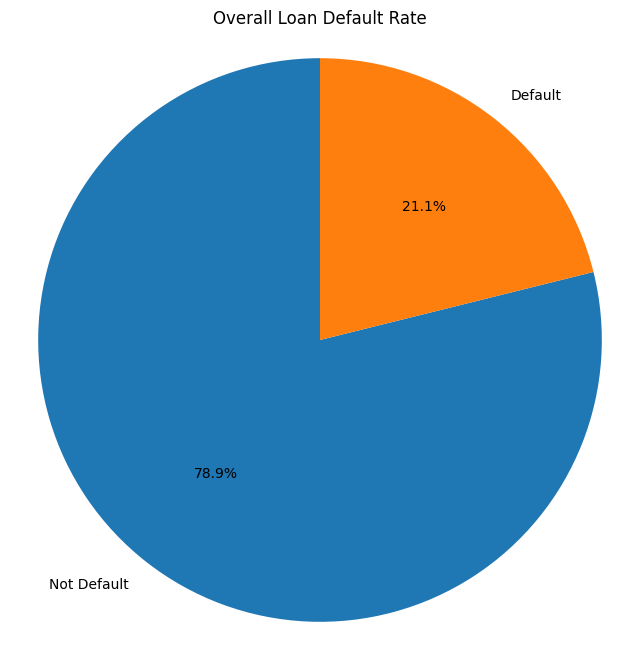

In [ ]:
# Calculate the value counts for the 'loan_default_dummy' column
default_counts = df['loan_default_dummy'].value_counts()

# Create a dictionary to map original labels to new labels
label_mapping = {
    0: 'Not Default',
    1: 'Default'
}

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(default_counts,
        labels=[label_mapping[label] for label in default_counts.index],  # Apply label mapping
        autopct='%1.1f%%',
        startangle=90)
plt.title('Overall Loan Default Rate')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Extract the loan issue year
df['issue_year'] = pd.to_datetime(df['issue_d'], format='%b-%y').dt.year

# Calculate the number of loans and default rate for each year
loan_counts_by_year = df.groupby('issue_year')['issue_year'].count()
default_rates_by_year = df.groupby('issue_year')['loan_default_dummy'].mean()

# Print the results
print("\nNumber of loans for each year:")
print(loan_counts_by_year)
print("\nDefault rate for each year:")
print(default_rates_by_year)

# Calculate the number of years of data
num_years = len(df['issue_year'].unique())
print(f"\nNumber of years of data: {num_years}")


Number of loans for each year:
issue_year
2015    375546
2016    115072
2017     88346
2018     32839
Name: issue_year, dtype: int64

Default rate for each year:
issue_year
2015    0.201850
2016    0.233854
2017    0.238709
2018    0.164591
Name: loan_default_dummy, dtype: float64

Number of years of data: 4


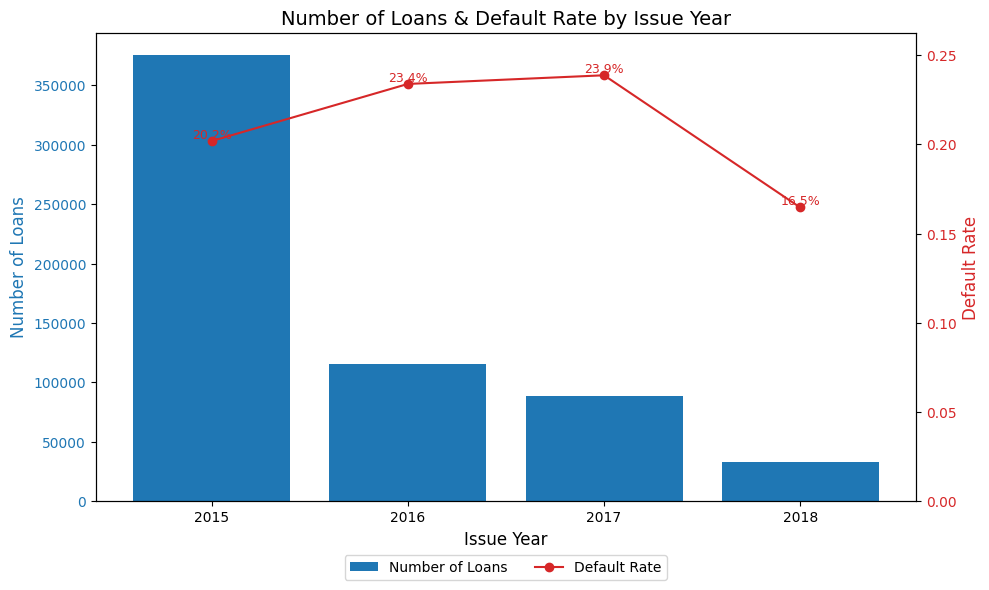

In [ ]:
color_blue = '#1f77b4'
color_red = '#d62728'

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert the index to string (for better x-axis labeling)
years = loan_counts_by_year.index.astype(str)

# Plot the bar chart for number of loans on the primary axis and capture the container
bar_container = ax1.bar(years, loan_counts_by_year.values, color=color_blue, label='Number of Loans')
ax1.set_xlabel('Issue Year', fontsize=12)
ax1.set_ylabel('Number of Loans', color=color_blue, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_blue)
ax1.set_title("Number of Loans & Default Rate by Issue Year", fontsize=14)

# Create a secondary y-axis for the default rate line chart
ax2 = ax1.twinx()

# Plot the default rate line chart and capture the line handle
line_handle, = ax2.plot(years, default_rates_by_year.values, color=color_red, marker='o', linestyle='-', label='Default Rate')
ax2.set_ylabel('Default Rate', color=color_red, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_red)
ax2.set_ylim(0, default_rates_by_year.max() * 1.1)

# Add data labels for the default rate line chart (as percentages)
for x, y in zip(years, default_rates_by_year.values):
    ax2.text(x, y, f"{y*100:.1f}%", color=color_red, ha='center', va='bottom', fontsize=9)

# Manually extract a representative handle from the bar container
bar_handle = bar_container.patches[0]

# Combine both handles into a single legend placed outside the chart at the bottom
ax1.legend([bar_handle, line_handle], ['Number of Loans', 'Default Rate'],
           loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.show()


# 2. Exploratory Data Analysis
* 2.1.	 Exploring important variables

In [ ]:
def categorize_income_cat(income):
  if income <= 20000:
    return "Low Income"
  elif income <= 80000:
    return "Medium Income"
  elif income > 80000:
    return "High Income"
  else:
    return "Unknown"

def categorize_dti_cat(dti):
  if dti <= 28:
    return "Good"
  elif dti < 40:
    return "Fair"
  elif dti >= 40:
    return "Bad"
  else:
    return "Unknown"

def categorize_fico_cat(fico):
  if fico < 580:
    return "Poor"
  elif fico <= 669:
    return "Fair"
  elif fico <= 739:
    return "Good"
  elif fico >= 740:
    return "Very Good"
  else:
    return "Unknown"

def gen_custom_categories(df, column_name, bins):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    bin_width = (max_val - min_val) / bins
    # This will generate (bins - 1) thresholds
    thresholds = [min_val + (i+1) * bin_width for i in range(bins - 1)]
    return thresholds

loan_amount_thresholds = gen_custom_categories(df, "loan_amnt", 3)
print(f'Loan amount threshold: {loan_amount_thresholds}')

chargeoff_thresholds = gen_custom_categories(df, "chargeoff_within_12_mths", 5)
print(f'Chargeoff threshold: {chargeoff_thresholds}')

deliquent_2yrs_thresholds = gen_custom_categories(df, "delinq_2yrs", 5)
print(f'Deliquent 2yrs threhold: {deliquent_2yrs_thresholds}')

# # Calculate the range and split it into three equal bins
# # Get the minimum and maximum loan amount from the DataFrame
# min_loan_amnt = df['loan_amnt'].min()
# max_loan_amnt = df['loan_amnt'].max()

# # Calculate the range and split it into three equal bins
# loan_amount_range = max_loan_amnt - min_loan_amnt
# bin_width = loan_amount_range / 3

# # Define the thresholds for small and medium loans
# small_threshold = min_loan_amnt + bin_width
# medium_threshold = min_loan_amnt + 2 * bin_width

def categorize_loan_amnt_cat(loan_amnt):
    # Categorize the loan amount
    if loan_amnt < loan_amount_thresholds[0]:
        return "small"
    elif loan_amnt < loan_amount_thresholds[1]:
        return "medium"
    else:
        return "large"

def categorize_chargeoff_within_12_mths(chargeoff_within_12_mths):
    # Categorize the number of charge-offs within 12 months
    if chargeoff_within_12_mths < chargeoff_thresholds[0]:
        return "small"
    elif chargeoff_within_12_mths < chargeoff_thresholds[1]:
        return "medium"
    elif chargeoff_within_12_mths < chargeoff_thresholds[2]:
        return "high medium"
    elif chargeoff_within_12_mths < chargeoff_thresholds[3]:
        return "large"
    else:
        return "very large"

def categorize_delinq_2yrs(delinq_2yrs):
  if delinq_2yrs < deliquent_2yrs_thresholds[0]:
    return "small"
  elif delinq_2yrs < deliquent_2yrs_thresholds[1]:
    return "medium"
  elif delinq_2yrs < deliquent_2yrs_thresholds[2]:
    return "high medium"
  elif delinq_2yrs < deliquent_2yrs_thresholds[3]:
    return "large"
  else:
    return "very large"

def categorize_emp_length (emp_length):
    if emp_length in ['< 1 year', '1 year', '2 years']:
        return "Newbie"
    elif emp_length in ['3 years', '4 years', '5 years', '6 years']:
        return "Mid"

    elif emp_length in ['7 years', '8 years', '9 years']:
        return "Experienced"
    elif emp_length in ['10+ years']:
        return "Senior"
    else:
        return "Unknown"

df_cat = df.copy(deep=True)

# Apply the functions to create the new columns
df_cat["Income_cat"] = df["annual_inc"].apply(categorize_income_cat)
df_cat["DTI_cat"] = df["dti"].apply(categorize_dti_cat)
df_cat["FICO_cat"] = df["fico_range_low"].apply(categorize_fico_cat)
df_cat["loan_amnt_cat"] = df["loan_amnt"].apply(categorize_loan_amnt_cat)
df_cat["chargeoff_within_12_mths_cat"] = df["chargeoff_within_12_mths"].apply(categorize_chargeoff_within_12_mths)
df_cat["delinq_2yrs_cat"] = df["delinq_2yrs"].apply(categorize_delinq_2yrs)
df_cat["emp_length_cat"] = df["emp_length"].apply(categorize_emp_length)

# Filter out rows with 'Unknown' in the specified columns
df_cat = df_cat[df_cat['Income_cat'] != 'Unknown']
df_cat = df_cat[df_cat['DTI_cat'] != 'Unknown']
df_cat = df_cat[df_cat['FICO_cat'] != 'Unknown']
df_cat = df_cat[df_cat['loan_amnt_cat'] != 'Unknown']
df_cat = df_cat[df_cat['chargeoff_within_12_mths_cat'] != 'Unknown']
df_cat = df_cat[df_cat['delinq_2yrs_cat'] != 'Unknown']
df_cat = df_cat[df_cat['emp_length_cat'] != 'Unknown']


print(f'Total data after filtering: {df_cat.shape[0]}')

df_cat.head()

Loan amount threshold: [14000.0, 27000.0]
Chargeoff threshold: [2.0, 4.0, 6.0, 8.0]
Deliquent 2yrs threhold: [7.8, 15.6, 23.4, 31.2]
Total data after filtering: 573237


id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  66624733      18000        18000          18000.0   60 months     19.48   
1  67849662       4225         4225           4225.0   36 months     14.85   
2  67715283      16000        16000          16000.0   36 months     12.88   
3  68341789      24250        24250          24250.0   60 months     24.24   
4  68415473      25000        25000          25000.0   60 months     13.99   

   installment grade sub_grade              emp_title  ...  \
0       471.70     E        E2       Software Manager  ...   
1       146.16     C        C5               mechanic  ...   
2       538.18     C        C2  Owner, Fee Appraiser   ...   
3       701.01     F        F3        hvac technician  ...   
4       581.58     C        C4    Executive Assistant  ...   

  debt_settlement_flag loan_default_dummy  issue_year     Income_cat DTI_cat  \
0                    N                  1        2015    High Income    Good   
1                    N                  1        2015  Medium Income    Good   
2                    N                  1        2015  Medium Income    Good   
3                    N                  1        2015  Medium Income    Good   
4                    N                  1        2015  Medium Income    Fair   

  FICO_cat loan_amnt_cat chargeoff_within_12_mths_cat delinq_2yrs_cat  \
0     Fair        medium                        small           small   
1     Good         small                        small           small   
2     Good        medium                        small           small   
3     Fair        medium                        small           small   
4     Good        medium                        small           small   

  emp_length_cat  
0    Experienced  
1            Mid  
2         Senior  
3            Mid  
4    Experienced  

[5 rows x 123 columns]

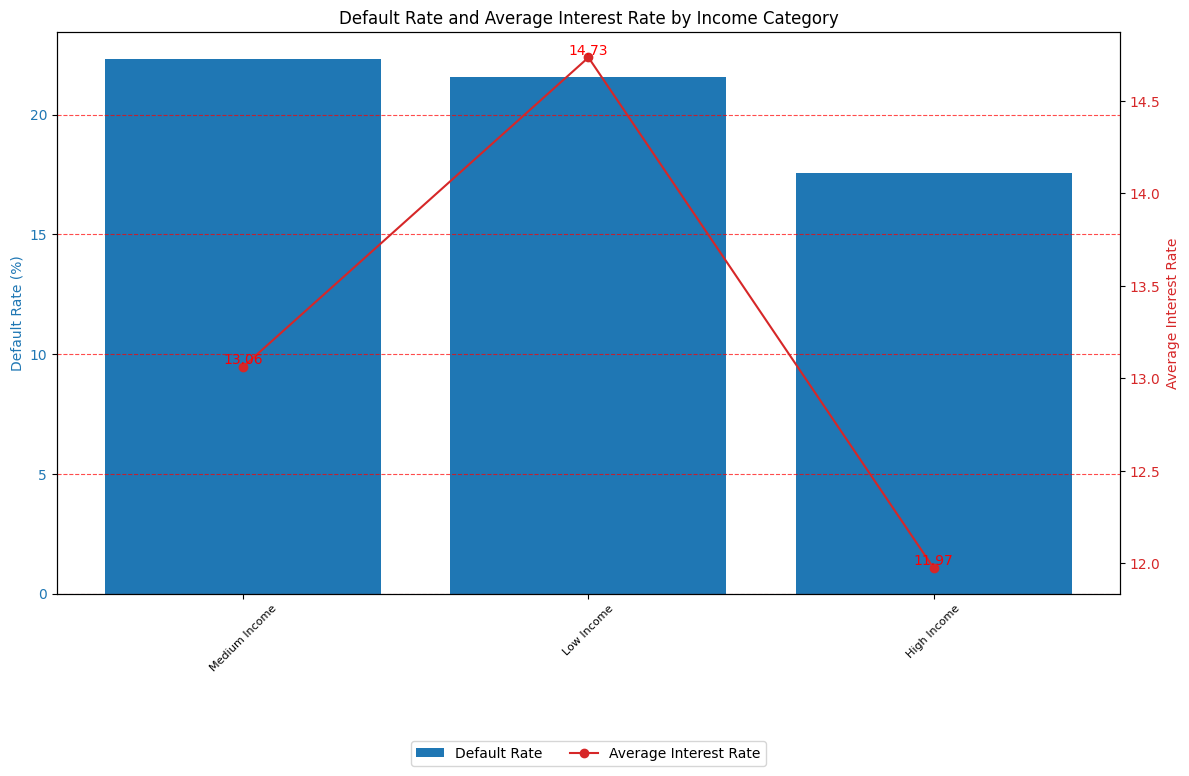

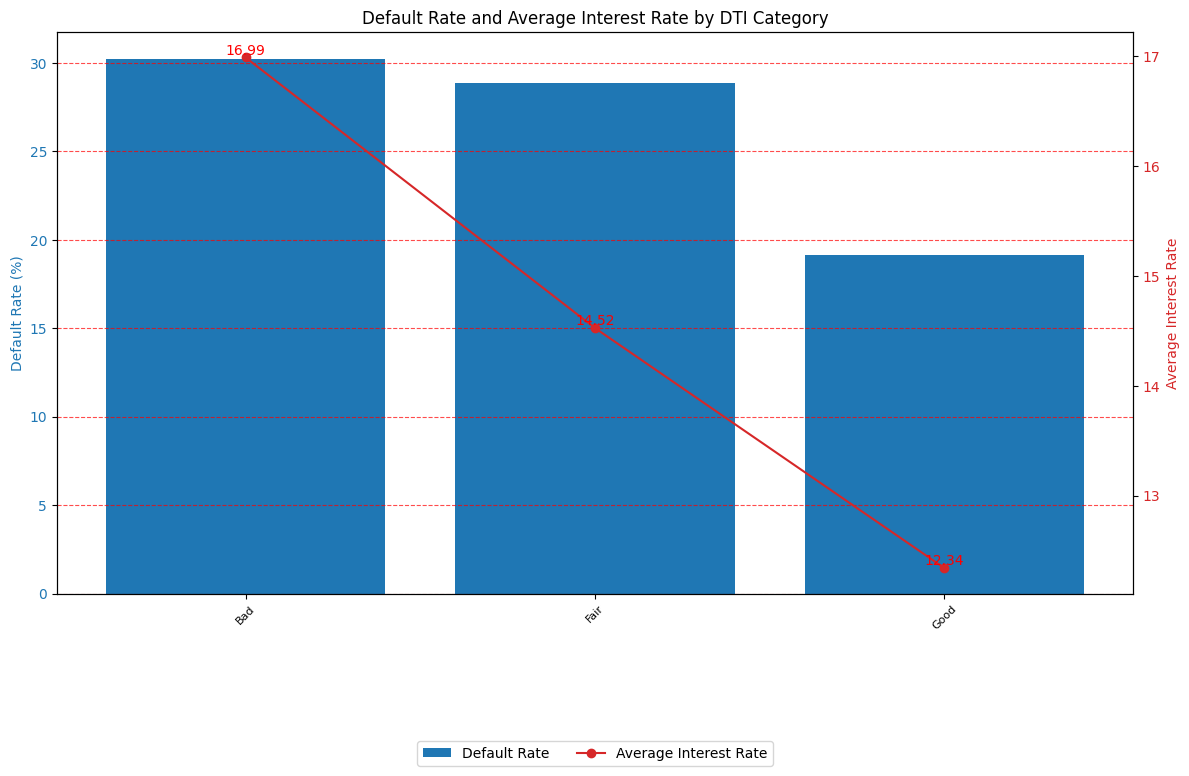

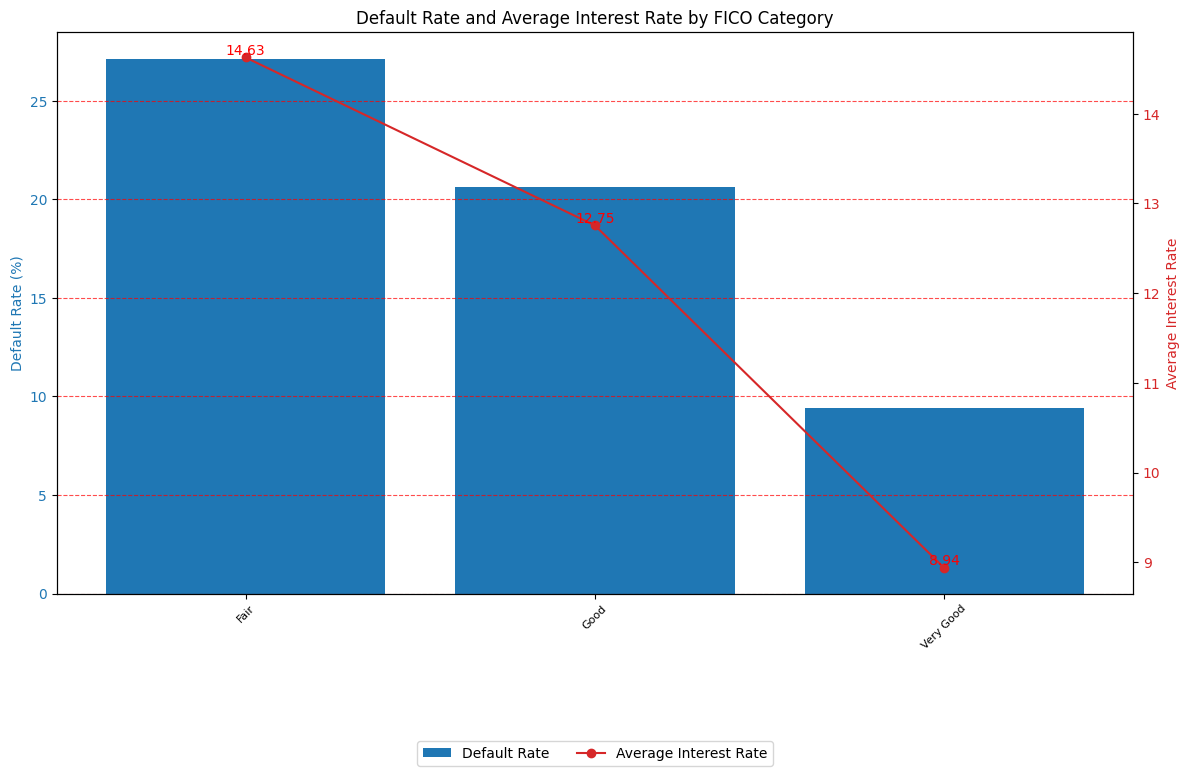

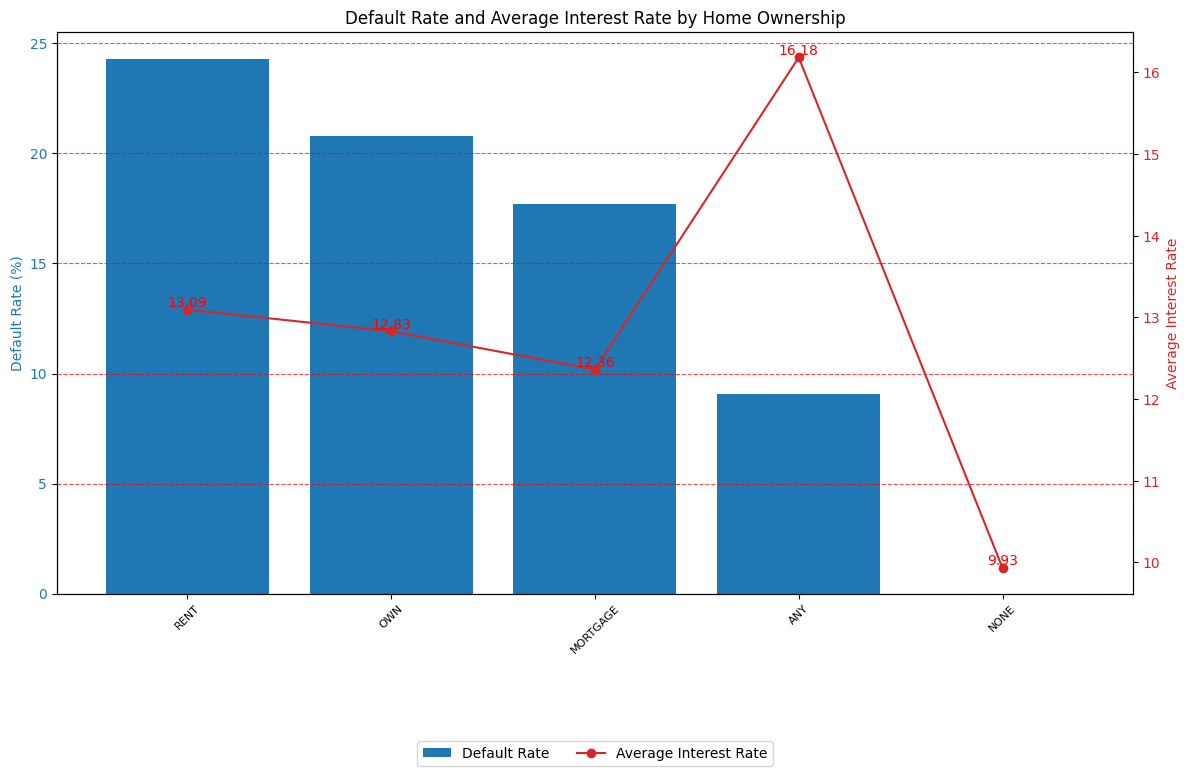

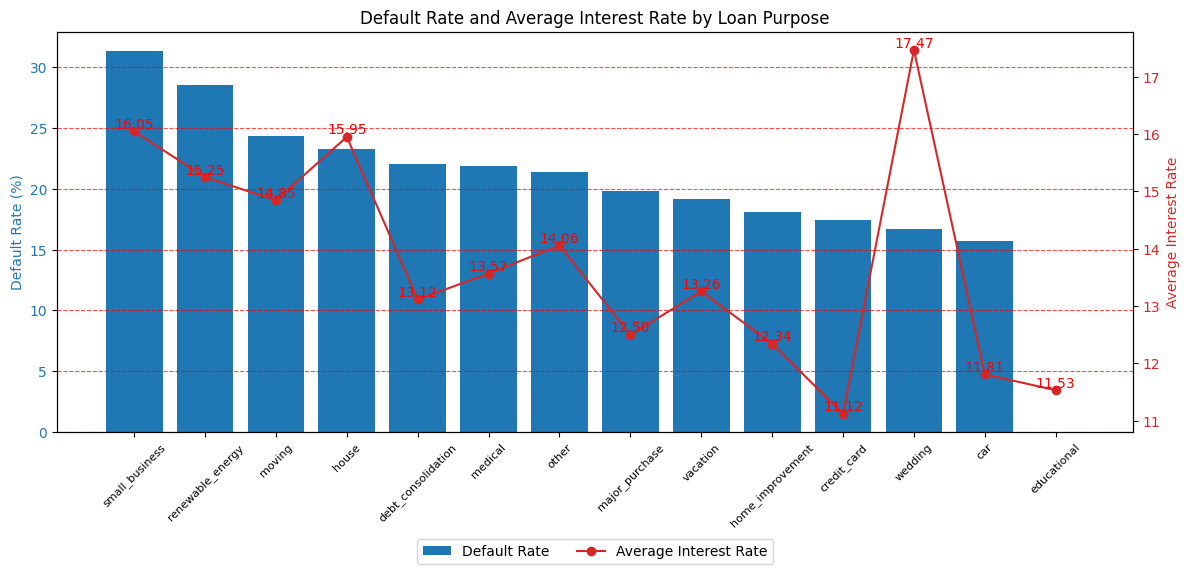

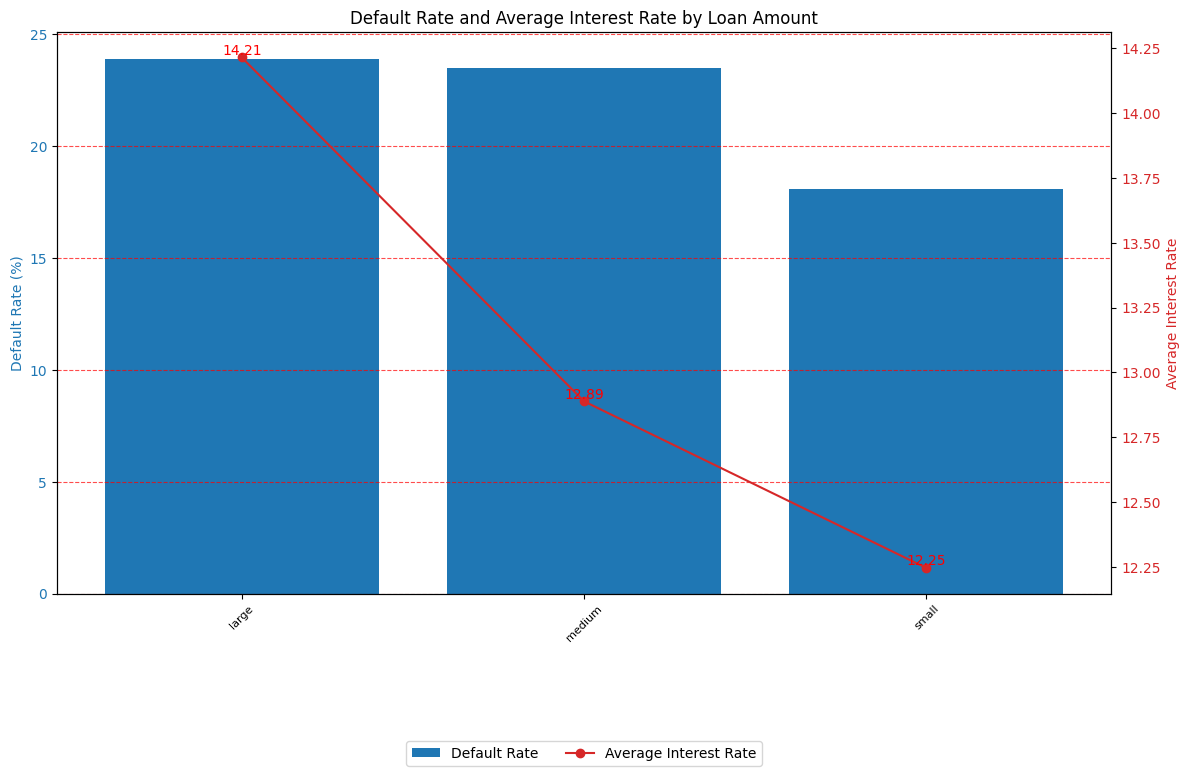

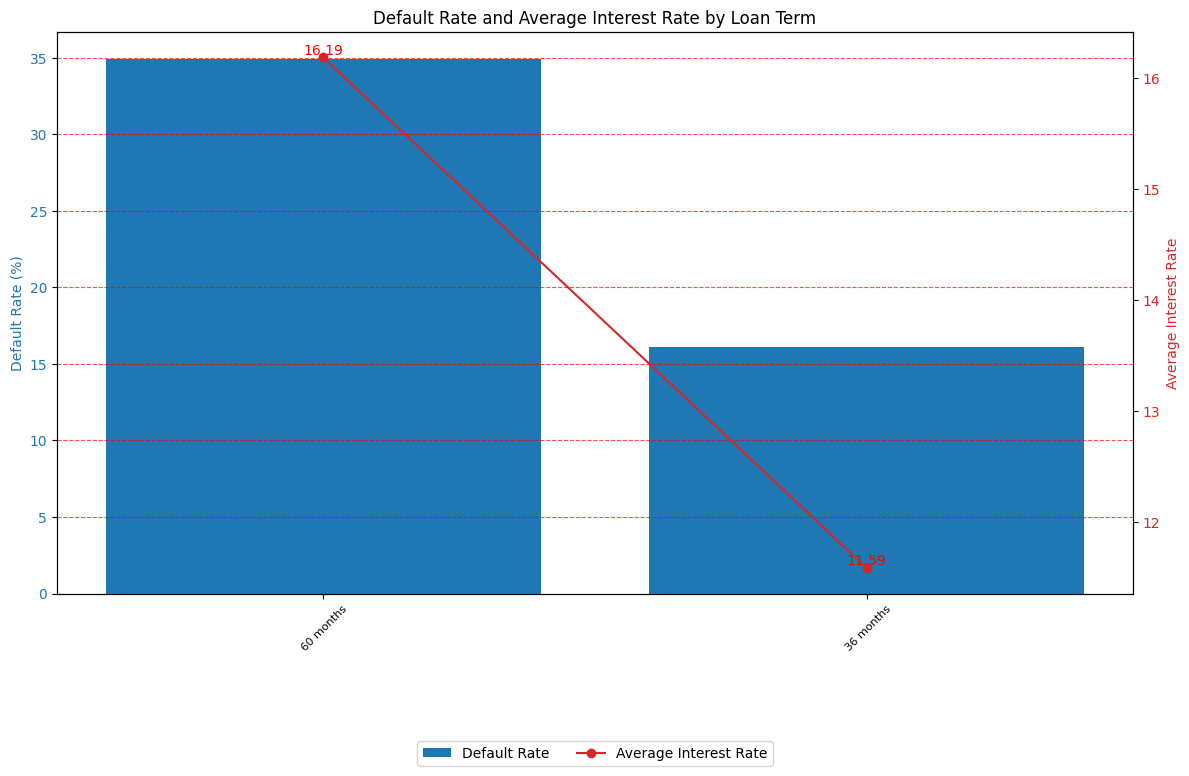

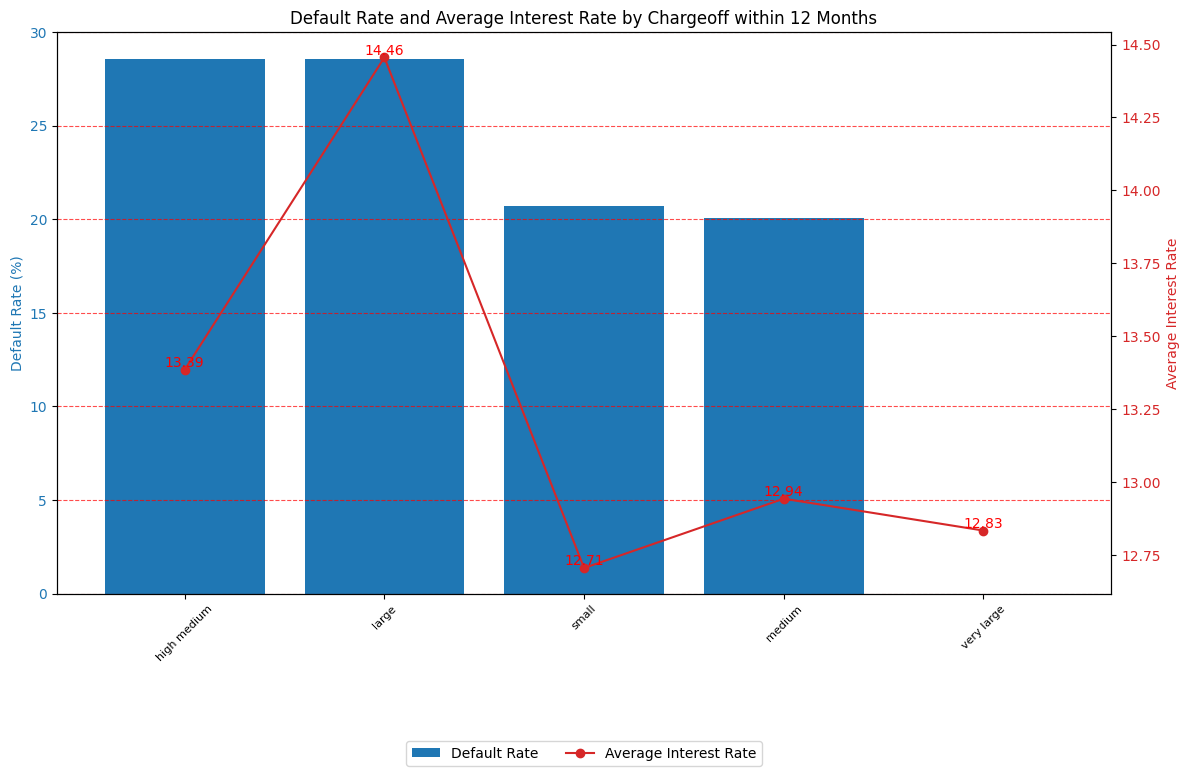

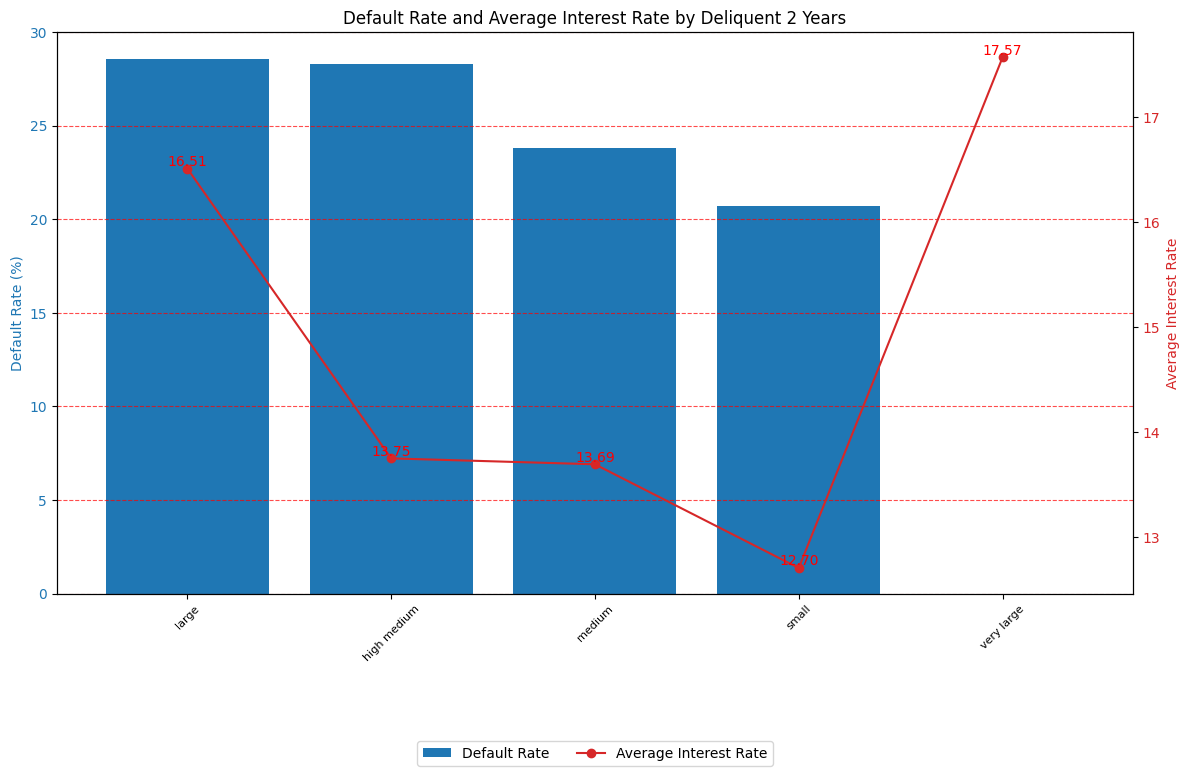

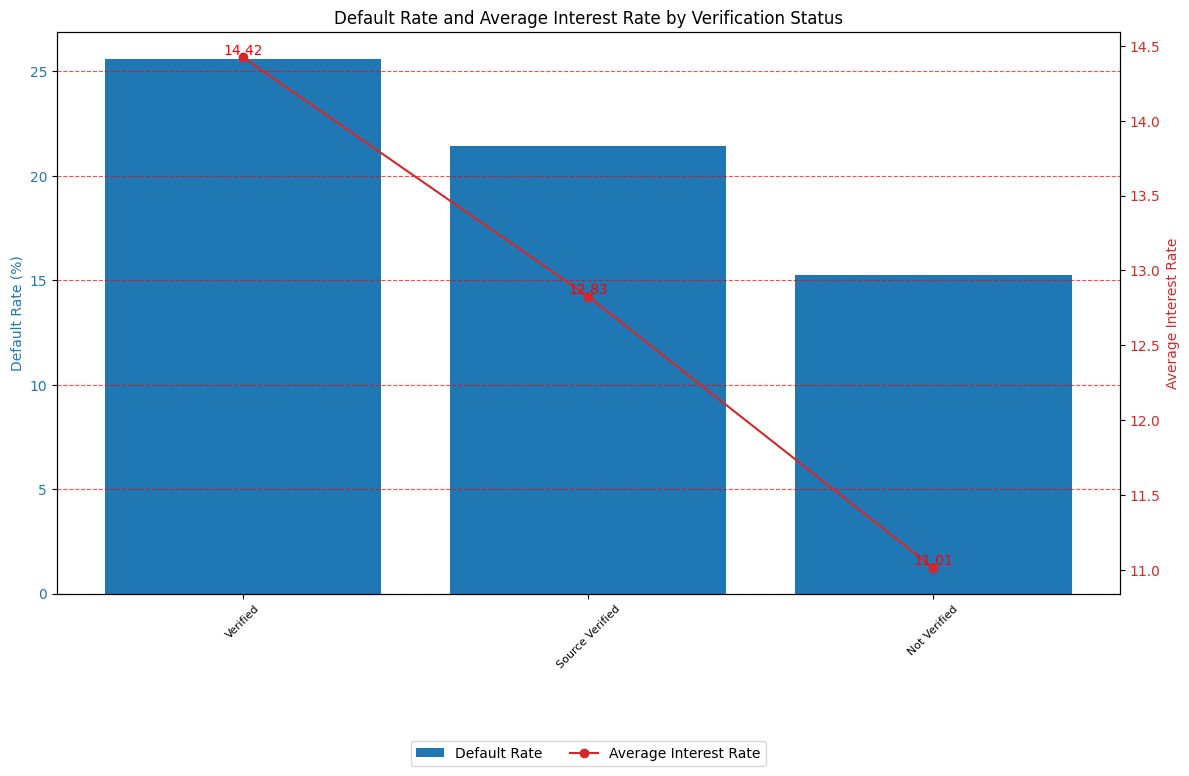

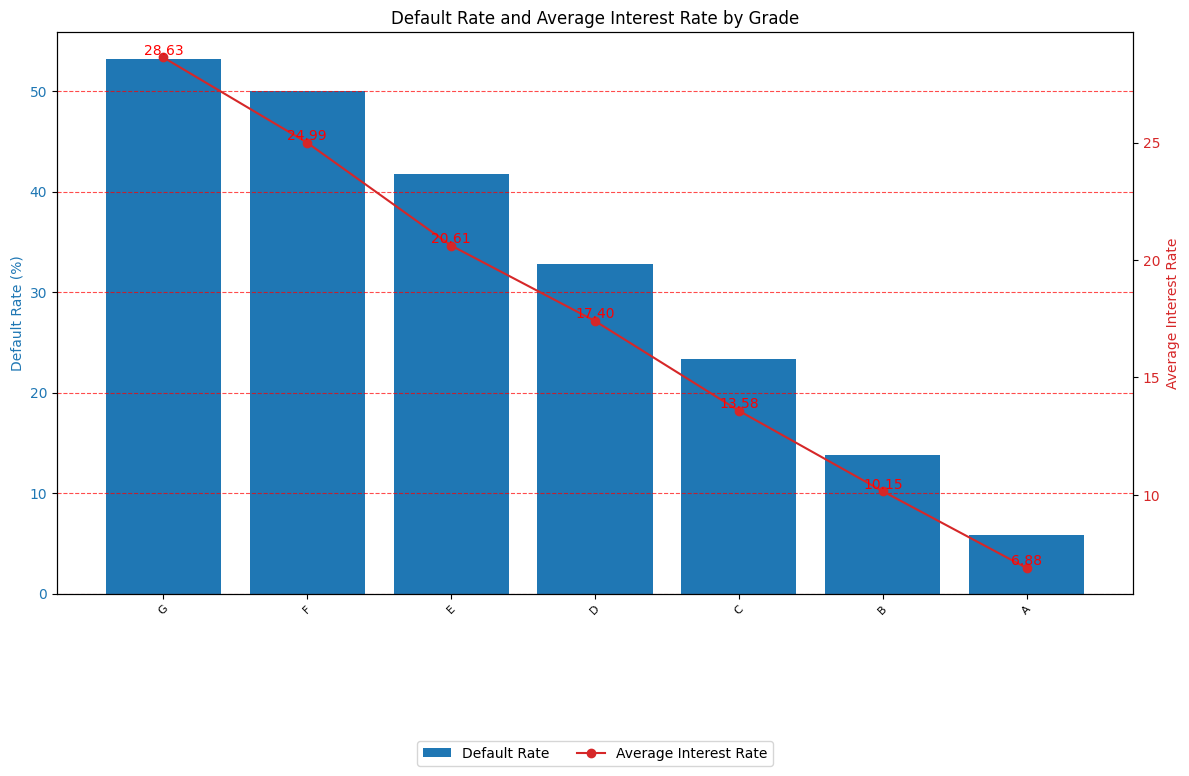

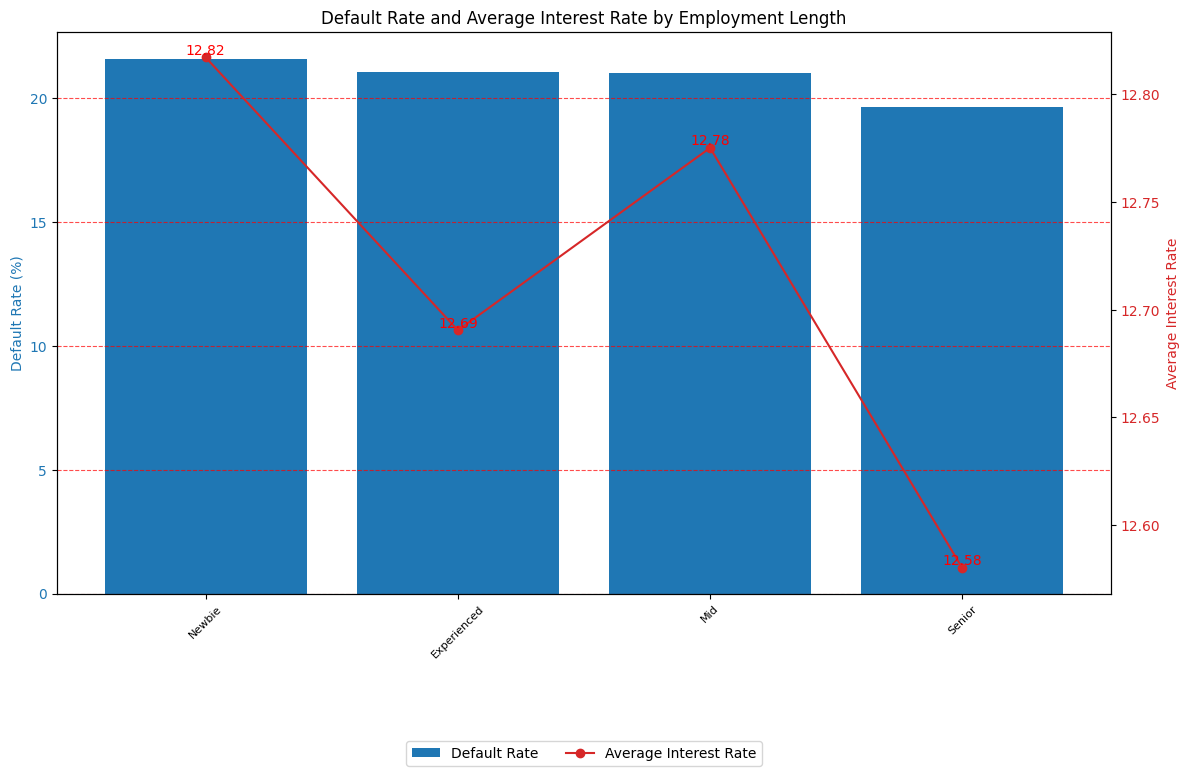

In [ ]:
def plot_default_interest_rate_by_category(df, group_col, chart_title, figsize=(12, 8)):
    # Group the data by the specified column and calculate the stats
    stats = df_cat.groupby(group_col).agg(
        default_rate=('loan_default_dummy', 'mean'),
        avg_int_rate=('int_rate', 'mean')
    ).reset_index()

    # Sort the results by default rate in descending order
    stats = stats.sort_values('default_rate', ascending=False)

    # Create the figure and primary axis
    fig, ax1 = plt.subplots(figsize=figsize)
    bars = ax1.bar(stats[group_col], stats['default_rate'] * 100, color=color_blue, label='Default Rate')

    # Customize primary y-axis for default rate
    ax1.set_ylabel('Default Rate (%)', color=color_blue)
    ax1.tick_params(axis='y', labelcolor=color_blue)
    ax1.grid(axis='y', linestyle='--', alpha=0.7, color='red')
    ax1.tick_params(axis='x', rotation=45, labelsize=8)

    # Create the secondary y-axis for average interest rate
    ax2 = ax1.twinx()
    ax2.plot(stats[group_col], stats['avg_int_rate'], color=color_red, marker='o', linestyle='-', label='Average Interest Rate')
    ax2.set_ylabel('Average Interest Rate', color=color_red)
    ax2.tick_params(axis='y', labelcolor=color_red)

    # Add data labels for the average interest rate values
    for x, y in zip(stats[group_col], stats['avg_int_rate']):
        ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', color='red', fontsize=10)

    # Customize the chart title and x-axis labels (rotated for better readability)
    plt.title(chart_title)

    # Combine legends from both axes and position it outside the chart
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2,
               loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    plt.tight_layout()
    plt.show()


# Example usage for different categories:
# 1. Income Category
plot_default_interest_rate_by_category(df, 'Income_cat',
    'Default Rate and Average Interest Rate by Income Category')

# 2. DTI Category
plot_default_interest_rate_by_category(df, 'DTI_cat',
    'Default Rate and Average Interest Rate by DTI Category')

# 3. FICO Category
plot_default_interest_rate_by_category(df, 'FICO_cat',
    'Default Rate and Average Interest Rate by FICO Category')

# 4. Home Ownership
plot_default_interest_rate_by_category(df, 'home_ownership',
    'Default Rate and Average Interest Rate by Home Ownership')

# 5. Loan Purpose
# Adjusting the figure size slightly to accommodate more categories if needed.
plot_default_interest_rate_by_category(df, 'purpose',
    'Default Rate and Average Interest Rate by Loan Purpose', figsize=(12,6))

# 6. Loan Amount
plot_default_interest_rate_by_category(df, 'loan_amnt_cat',
    'Default Rate and Average Interest Rate by Loan Amount')

# 7. Loan Term
plot_default_interest_rate_by_category(df, 'term',
    'Default Rate and Average Interest Rate by Loan Term')

# 8. Charge off time within 12 months
plot_default_interest_rate_by_category(df, 'chargeoff_within_12_mths_cat',
    'Default Rate and Average Interest Rate by Chargeoff within 12 Months')

# 9. Deliquent 2 years
plot_default_interest_rate_by_category(df, 'delinq_2yrs_cat',
    'Default Rate and Average Interest Rate by Deliquent 2 Years')

# 10. Verification Status
plot_default_interest_rate_by_category(df, 'verification_status',
    'Default Rate and Average Interest Rate by Verification Status')

# 11. Grade
plot_default_interest_rate_by_category(df, 'grade',
    'Default Rate and Average Interest Rate by Grade')

# 12. Emp length
plot_default_interest_rate_by_category(df, 'emp_length_cat',
    'Default Rate and Average Interest Rate by Employment Length')



Data point counts by loan amount category and term:
 term           36 months  60 months
loan_amnt_cat                      
large              36885      30561
medium            125021      79017
small             271882      29871


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


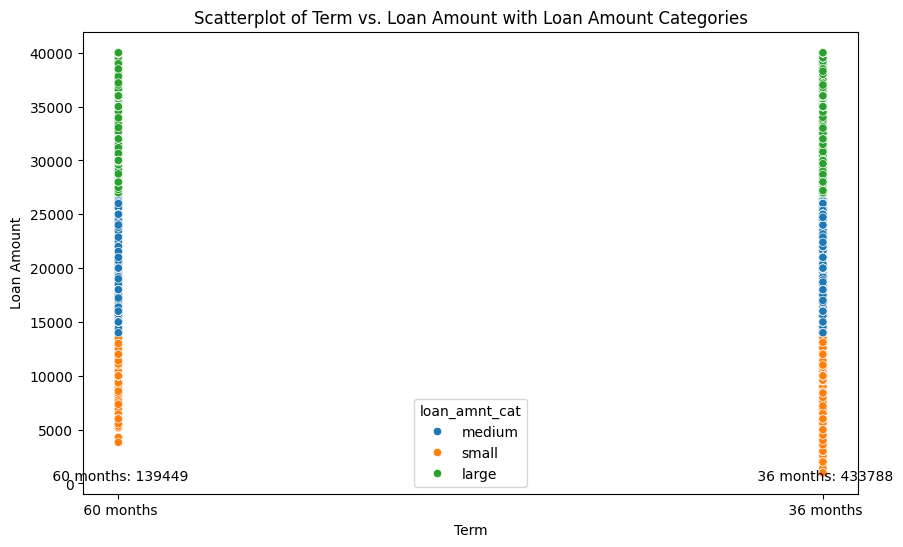

In [ ]:
# prompt: create a scatterplot of term and loan amount cat, with term on the x axis. Also, for points that are in the same loan amount category will have the same color, I also want to display how many loan is in the 36 month term and how many is in the 60 month term, I also want to see how many datapoint in each category and in each term

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cat is your DataFrame as defined in the provided code
# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='term', y='loan_amnt', hue='loan_amnt_cat', data=df_cat)
plt.xlabel('Term')
plt.ylabel('Loan Amount')
plt.title('Scatterplot of Term vs. Loan Amount with Loan Amount Categories')

# Calculate and display the counts of loans for each term
term_counts = df_cat['term'].value_counts()
for term, count in term_counts.items():
    plt.text(term, 0, f'{term}: {count}', ha='center', va='bottom')


# Calculate and display counts of data points in each loan_amnt_cat and term
loan_term_counts = df_cat.groupby(['loan_amnt_cat', 'term']).size().unstack(fill_value=0)
print("\nData point counts by loan amount category and term:\n", loan_term_counts)

plt.show()


# **3. Machine Learning Models**


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from ISLP import confusion_table
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
dependent_var = "loan_default_dummy"

# Use this one
chosen_predictors = [
    'DTI_cat',
    'FICO_cat',
    'Income_cat',
    'purpose',
    'home_ownership',
    'term',
    'loan_amnt_cat',
    'verification_status',
    'grade',
    'emp_length_cat'
    ]

# Correlation

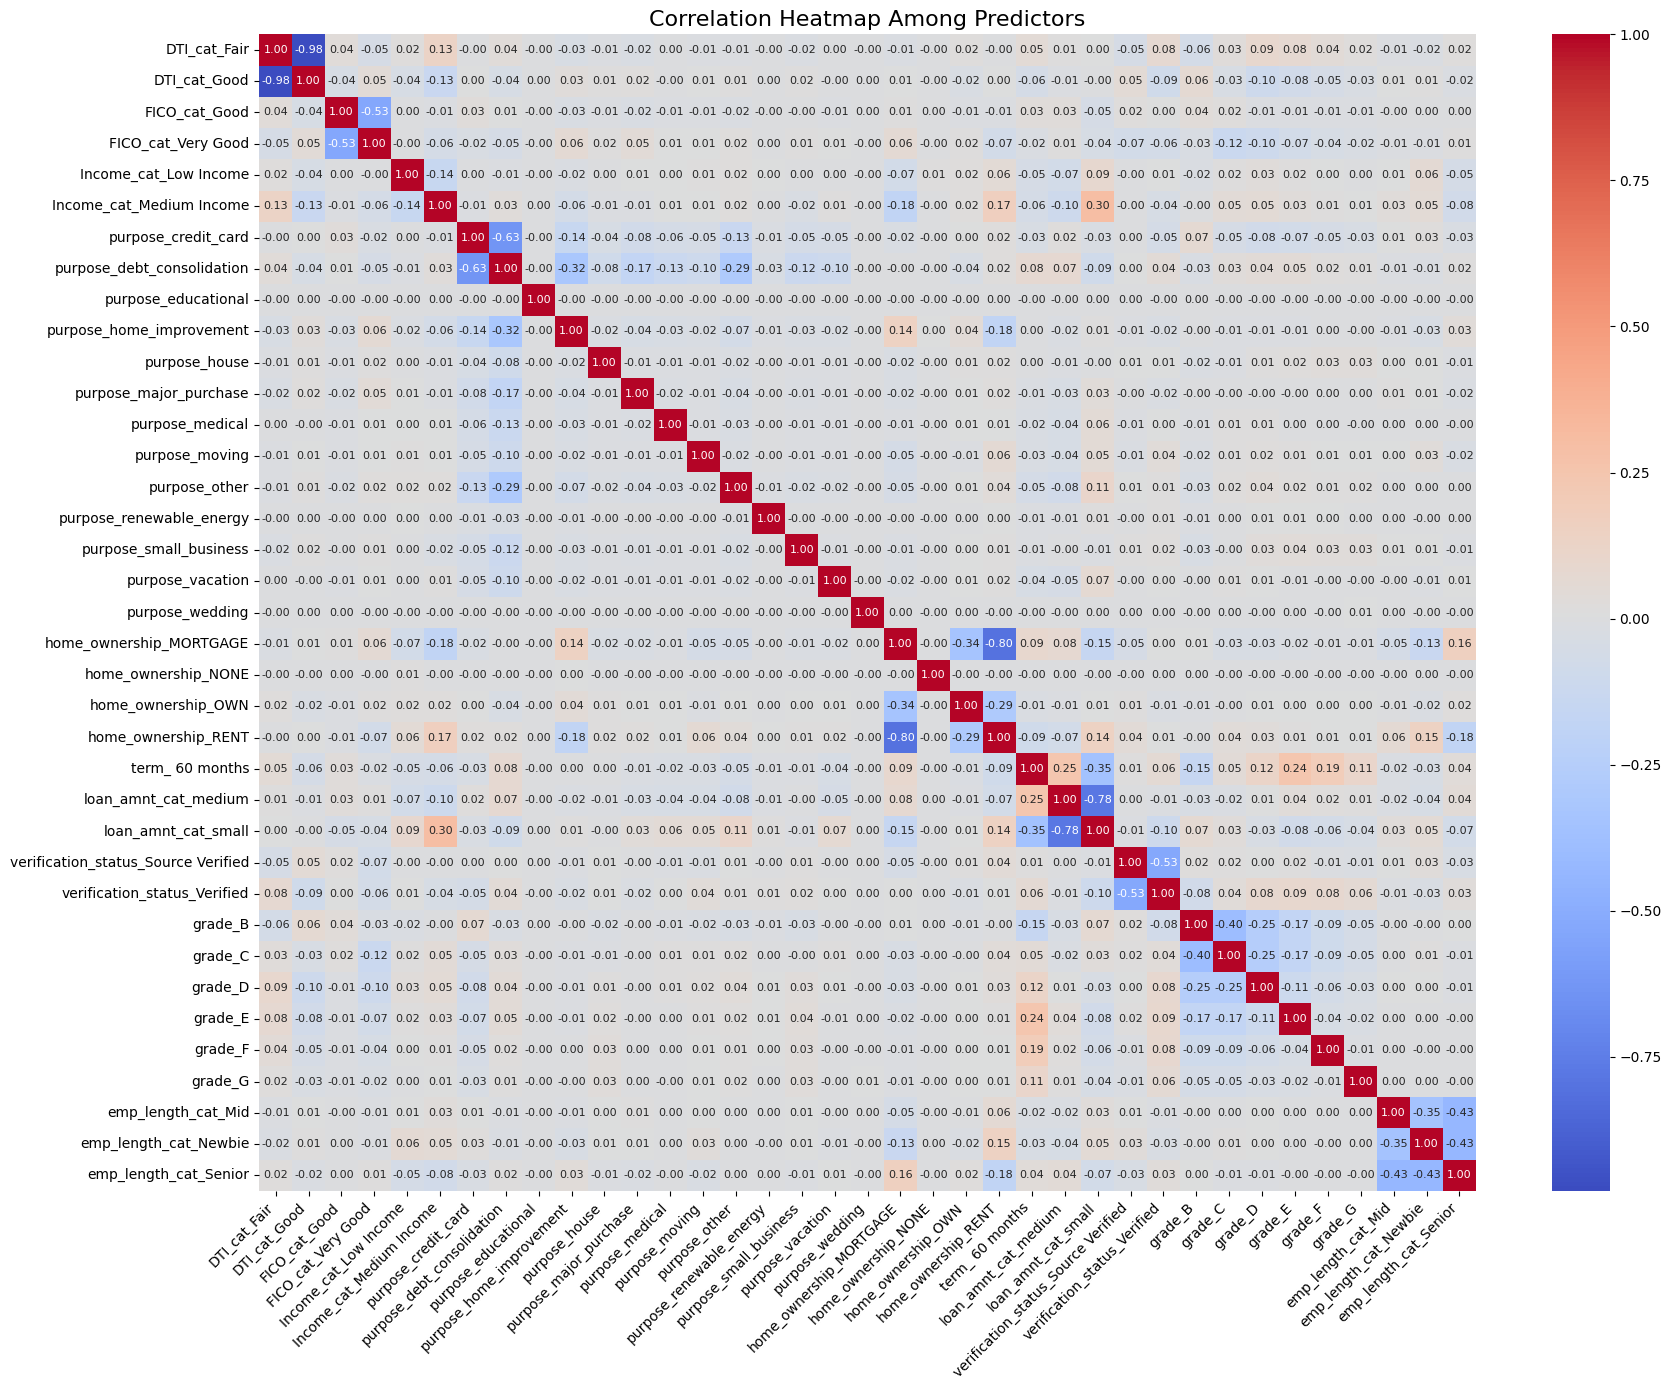

In [ ]:
plt.figure(figsize=(18, 14))  # Increase figure size
sns.heatmap(
    corr_matrix,
    annot=True,            # Show correlation coefficients
    fmt=".2f",             # Format numbers to 2 decimal places
    cmap="coolwarm",
    annot_kws={"size": 8}  # Set annotation text size
)

plt.title("Correlation Heatmap Among Predictors", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()                   # Automatically adjust layout to prevent clipping
plt.show()

# Cleaning Dataset

In [ ]:
def clean_dataset(df, predictor_lists, dependent_var):
    selected_columns = predictor_lists + [dependent_var]
    df_selected = df[selected_columns].copy()

    df_cleaned = df_selected.dropna()

    categorical_cols = [col for col in predictor_lists if df_cleaned[col].dtype == 'object']
    df_with_dummies = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

    #Transform to type int
    bool_cols = df_with_dummies.select_dtypes(include=['bool']).columns
    df_with_dummies[bool_cols] = df_with_dummies[bool_cols].astype(int)

    all_predictors = [col for col in df_with_dummies if (df_with_dummies[col].dtype != 'object' and col != dependent_var)]

    for col in all_predictors:
        print(f"{col}: {df_with_dummies[col].dtype}")
    return df_with_dummies, all_predictors

def create_my_test_train(pred_list):
    df_model_run, predictors = clean_dataset(df_cat.copy(), pred_list, dependent_var)
    print(predictors)

    X_model1 = MS(predictors).fit_transform(df_model_run)
    y_model1 = df_model_run[dependent_var] == True


    #split train test 80 -20
    X_train, X_test, y_train, y_test = train_test_split(X_model1, y_model1, test_size=0.2, random_state=42)


    feature_names = X_model1.columns

    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)
    return X_train, X_test, y_train, y_test, feature_names

def create_sample_test_train(pred_list, n_samples=500):
    # Clean the dataset and get predictors
    df_model_run, predictors = clean_dataset(df_cat.copy(), pred_list, dependent_var)
    print("Predictors:", predictors)

    # Subsample the data to n_samples rows (if available)
    if n_samples < len(df_model_run):
        df_model_run = df_model_run.sample(n=n_samples, random_state=42)
        print(f"Subsampled data to {n_samples} rows.")
    else:
        print("n_samples is greater than available rows; using full dataset.")

    # Transform predictors using your custom transformation object MS
    X_model1 = MS(predictors).fit_transform(df_model_run)
    y_model1 = df_model_run[dependent_var] == True

    X_train, X_test, y_train, y_test = train_test_split(
        X_model1, y_model1, test_size=0.2, random_state=42
    )


    feature_names = X_model1.columns
    print("Predictors:", feature_names)

    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)

    return X_train, X_test, y_train, y_test, feature_names

# Training Data

In [ ]:
def train_test(model, X_train, X_test, y_train, y_test, model_type, feature_names):
    if model_type not in ('logistic', 'ridge', 'lasso', 'random_forest'):
        raise ValueError("Invalid model type. Must be one of 'logistic', 'ridge', 'lasso'.")

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:,1]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_.ravel()})
    return y_proba, coef_df


def graph_different_threshold(y_proba, y_test):
    thresholds_grid = np.linspace(0, 1, 100)
    accuracies = []
    recalls = []
    for threshold in thresholds_grid:
        y_pred_candidate = (y_proba >= threshold).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_candidate))
        recalls.append(recall_score(y_test, y_pred_candidate, zero_division=0))

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds_grid, accuracies, label="Accuracy", marker='o')
    plt.plot(thresholds_grid, recalls, label="Recall", marker='s')
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Accuracy and Recall vs. Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

def result_analysis(y_test, y_proba, threshold, model_type):
    y_pred = (y_proba >= threshold).astype(int)

    acc   = accuracy_score(y_test,  y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test,    y_pred, zero_division=0)
    f1    = f1_score(y_test,        y_pred, zero_division=0)

    results_df = pd.DataFrame({
        'Model Type': [model_type],
        'Accuracy':   [acc],
        'Precision':  [prec],
        'Recall':     [rec],
        'F1-Score':   [f1],
    })

    # 2) Confusion matrix + plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Non-Default','Pred Default'],
                yticklabels=['Actual Non-Default','Actual Default'])
    plt.title(f'Confusion Matrix \n Accuracy {round(acc, 3)} \n Recall {round(rec, 3)}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #3 ROC curve
    aoc = roc_auc_score(y_test, y_proba)
    results_df["AOC"] = aoc
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {aoc:.3f}')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return results_df

X_train_linear, X_test_linear, y_train, y_test, feature_names = create_my_test_train(chosen_predictors)
#X_train, X_test, y_train, y_test = create_tutor_test_train()


# X_train_linear, X_test_linear, y_train, y_test, feature_names = create_sample_test_train(predictors_main, 1000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_linear)
X_test  = scaler.transform(X_test_linear)

DTI_cat_Fair: int64
DTI_cat_Good: int64
FICO_cat_Good: int64
FICO_cat_Very Good: int64
Income_cat_Low Income: int64
Income_cat_Medium Income: int64
purpose_credit_card: int64
purpose_debt_consolidation: int64
purpose_educational: int64
purpose_home_improvement: int64
purpose_house: int64
purpose_major_purchase: int64
purpose_medical: int64
purpose_moving: int64
purpose_other: int64
purpose_renewable_energy: int64
purpose_small_business: int64
purpose_vacation: int64
purpose_wedding: int64
home_ownership_MORTGAGE: int64
home_ownership_NONE: int64
home_ownership_OWN: int64
home_ownership_RENT: int64
term_ 60 months: int64
loan_amnt_cat_medium: int64
loan_amnt_cat_small: int64
verification_status_Source Verified: int64
verification_status_Verified: int64
grade_B: int64
grade_C: int64
grade_D: int64
grade_E: int64
grade_F: int64
grade_G: int64
emp_length_cat_Mid: int64
emp_length_cat_Newbie: int64
emp_length_cat_Senior: int64
['DTI_cat_Fair', 'DTI_cat_Good', 'FICO_cat_Good', 'FICO_cat_Very

# 3.1 OLS Regression

                            OLS Regression Results                            
Dep. Variable:     loan_default_dummy   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     1389.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:29:42   Log-Likelihood:            -2.1204e+05
No. Observations:              458589   AIC:                         4.242e+05
Df Residuals:                  458551   BIC:                         4.246e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
in

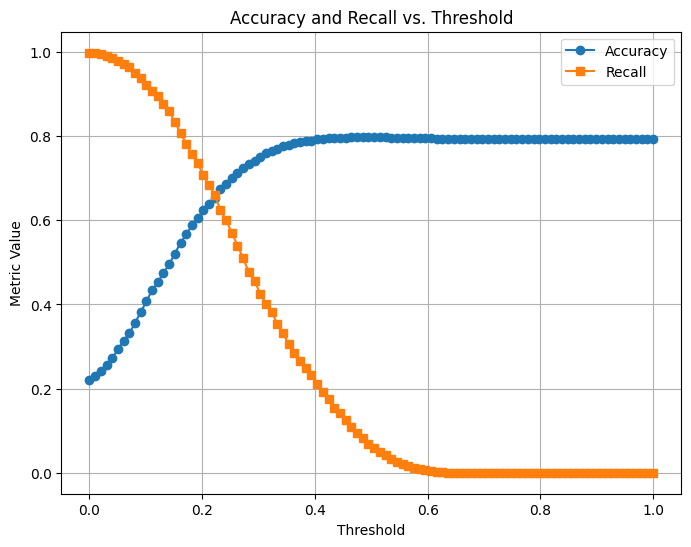

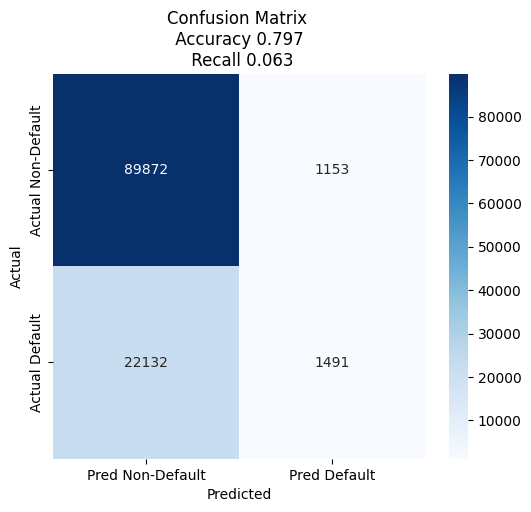

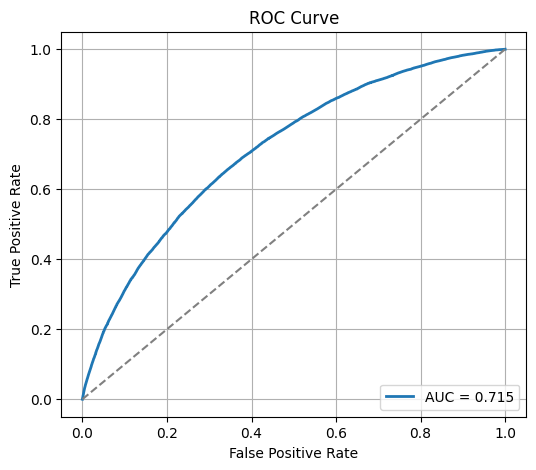

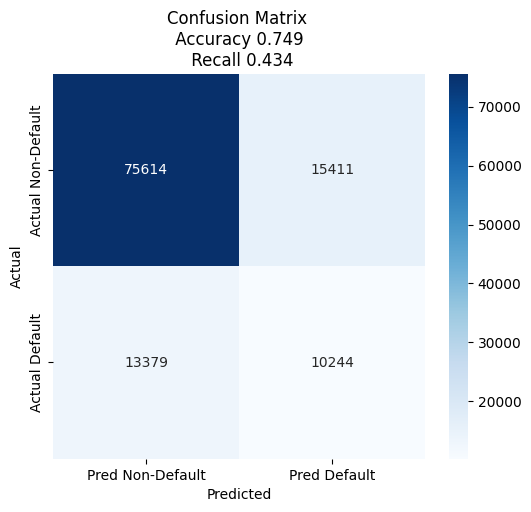

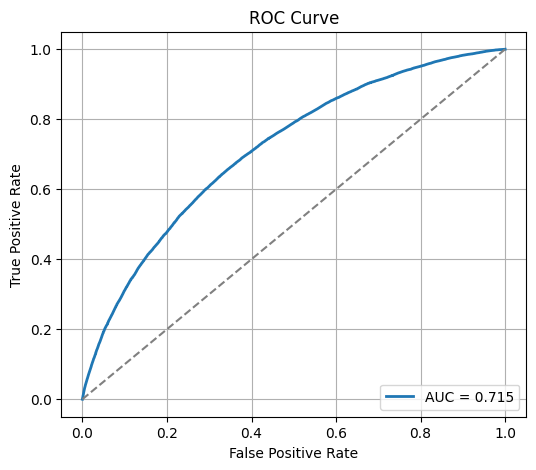

In [ ]:
#OLS
ols_model = sm.OLS(y_train, X_train_linear) # Switched the order of y_train and X_train_linear
ols_results = ols_model.fit()
print(ols_results.summary())

#Test
ols_reg = LinearRegression()
y_proba = ols_reg.fit(X_train, y_train).predict(X_test)
graph_different_threshold(y_proba, y_test)

#basic threshold
basic_threshold = 0.5
ols_df = result_analysis(y_test, y_proba, basic_threshold, 'ols')

#best threshold according to accuracy & recall
best_threshold = 0.3
ols_best_threshold_df = result_analysis(y_test, y_proba, best_threshold, 'ols')

# 3.2 Logistic Regression

                 Generalized Linear Model Regression Results                  
Dep. Variable:     loan_default_dummy   No. Observations:               458589
Model:                            GLM   Df Residuals:                   458552
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0217e+05
Date:                Wed, 16 Apr 2025   Deviance:                   6.0434e+05
Time:                        02:12:11   Pearson chi2:                 4.64e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            -0.3470
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.77e-20   1.76e-19      0.554      0.5

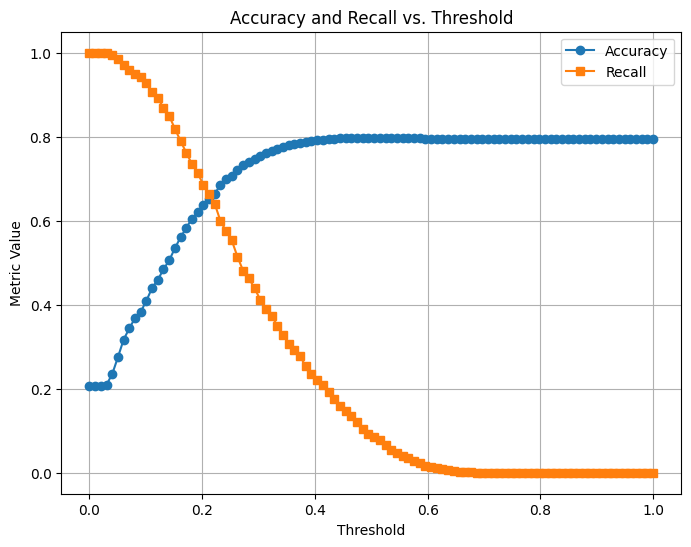

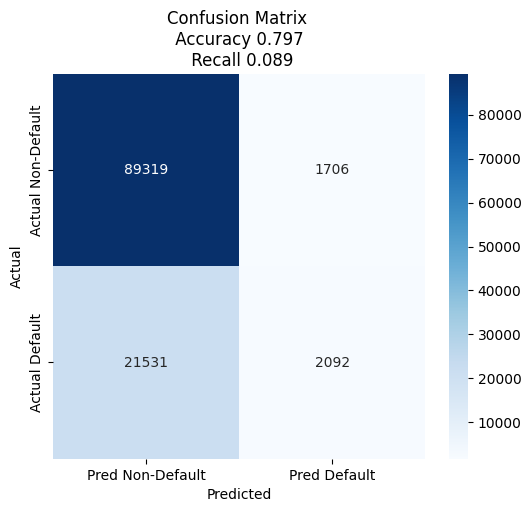

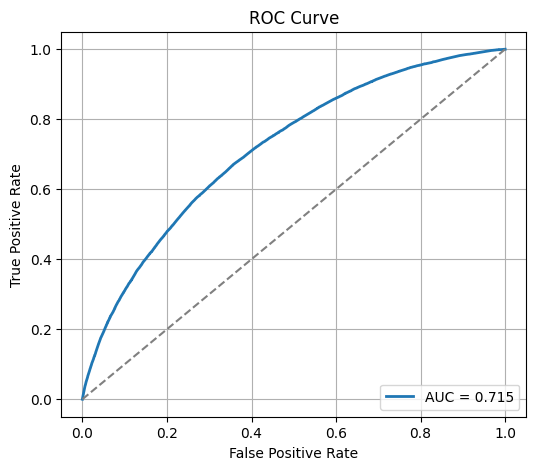

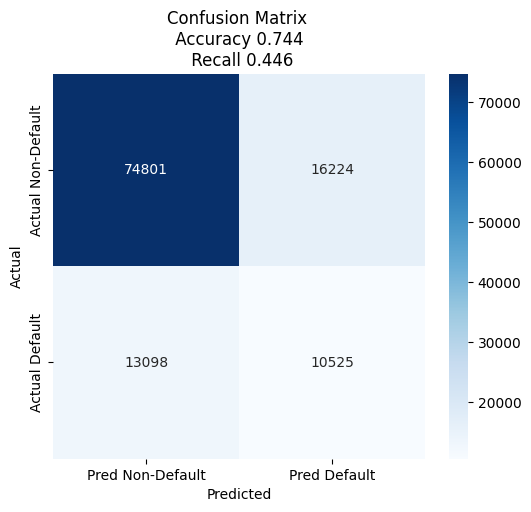

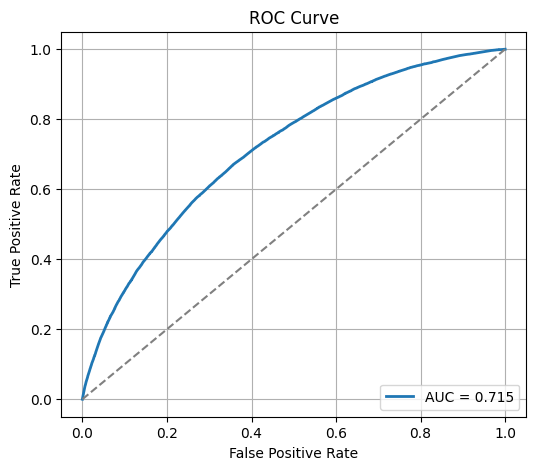

In [ ]:
#Logistic
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results_model1 = glm.fit()
print(results_model1.summary())

#Logistic
log_reg = LogisticRegression(random_state=42, max_iter=10000)
y_proba, coef_df = train_test(log_reg, X_train, X_test, y_train, y_test, 'logistic', feature_names)
graph_different_threshold(y_proba, y_test)

#basic threshold = 0.5
basic_threshold = 0.5
log_df = result_analysis(y_test, y_proba, basic_threshold, 'logistic')


#best threshold according to accuracy & recall
best_threshold = 0.29
log_best_threshold_df = result_analysis(y_test, y_proba, best_threshold, 'logistic')

# 3.3 Ridge Regression

DTI_cat_Fair: int64
DTI_cat_Good: int64
FICO_cat_Good: int64
FICO_cat_Very Good: int64
Income_cat_Low Income: int64
Income_cat_Medium Income: int64
purpose_credit_card: int64
purpose_debt_consolidation: int64
purpose_educational: int64
purpose_home_improvement: int64
purpose_house: int64
purpose_major_purchase: int64
purpose_medical: int64
purpose_moving: int64
purpose_other: int64
purpose_renewable_energy: int64
purpose_small_business: int64
purpose_vacation: int64
purpose_wedding: int64
home_ownership_MORTGAGE: int64
home_ownership_NONE: int64
home_ownership_OWN: int64
home_ownership_RENT: int64
term_ 60 months: int64
loan_amnt_cat_medium: int64
loan_amnt_cat_small: int64
verification_status_Source Verified: int64
verification_status_Verified: int64
grade_B: int64
grade_C: int64
grade_D: int64
grade_E: int64
grade_F: int64
grade_G: int64
emp_length_cat_Mid: int64
emp_length_cat_Newbie: int64
emp_length_cat_Senior: int64
Predictors: ['DTI_cat_Fair', 'DTI_cat_Good', 'FICO_cat_Good', 'F

train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335

Best α by CV recall = 0.001



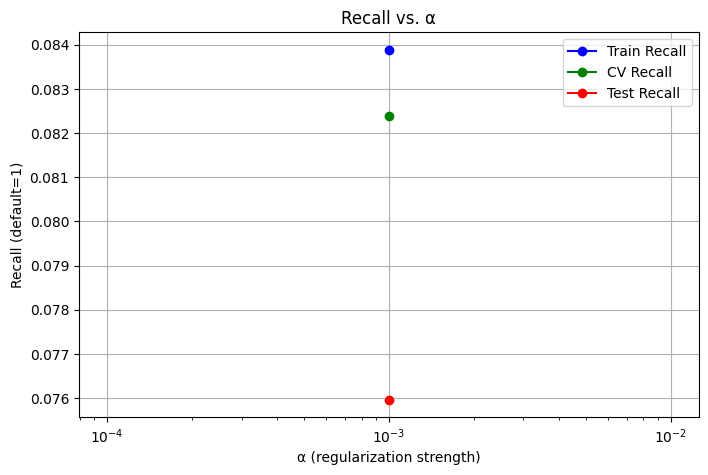

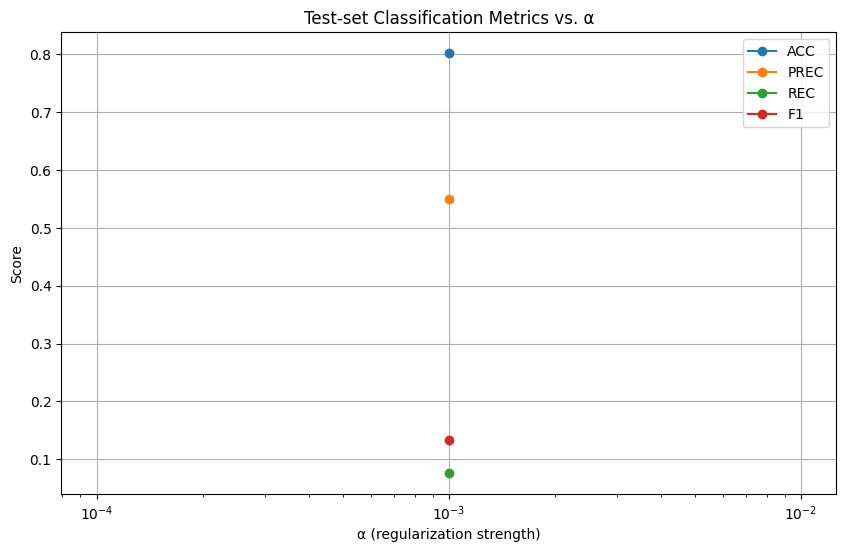

Ridge Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   
0.010      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335

Best α by CV recall = 0.001



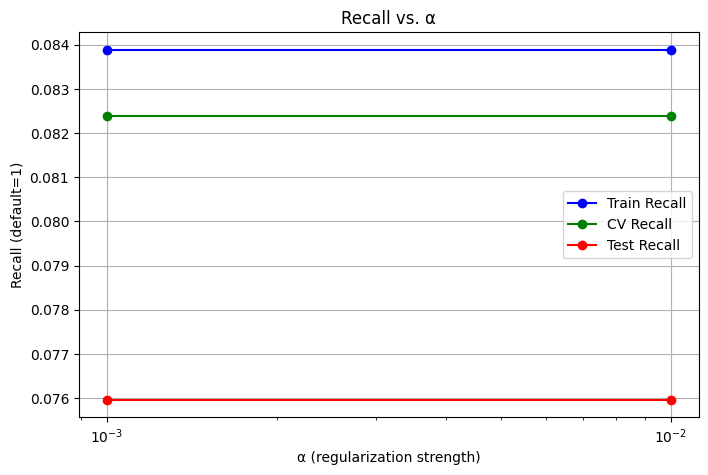

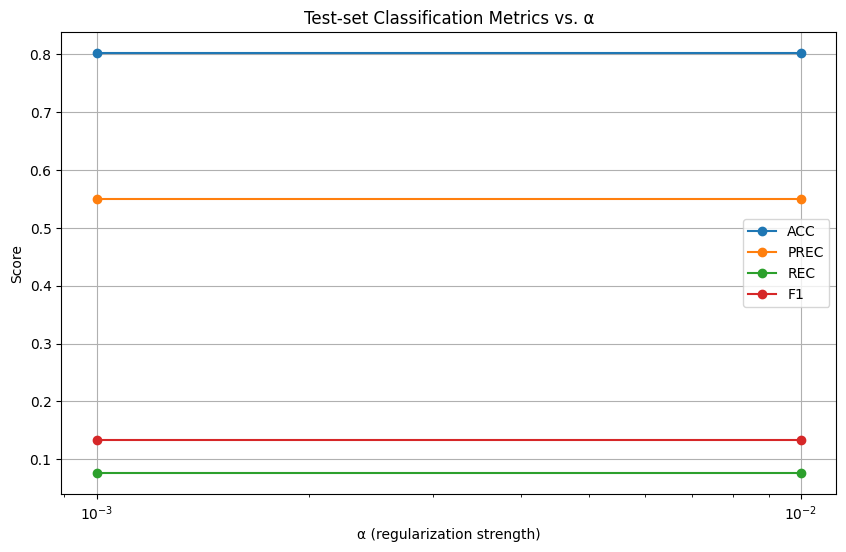

Ridge Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001     0.7950  0.7940    0.8020     0.0839  0.0824     0.076      0.5326   
0.010     0.7950  0.7940    0.8020     0.0839  0.0824     0.076      0.5326   
0.100     0.7951  0.7941    0.8022     0.0842  0.0824     0.076      0.5345   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335  
0.100     0.5545    0.1455   0.1336

Best α by CV recall = 0.001



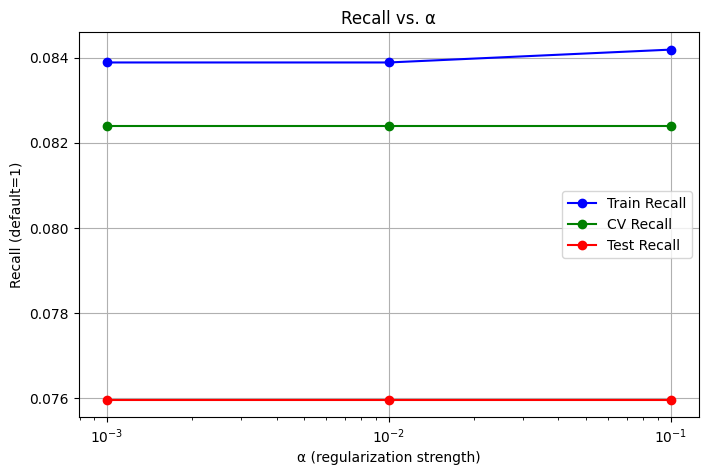

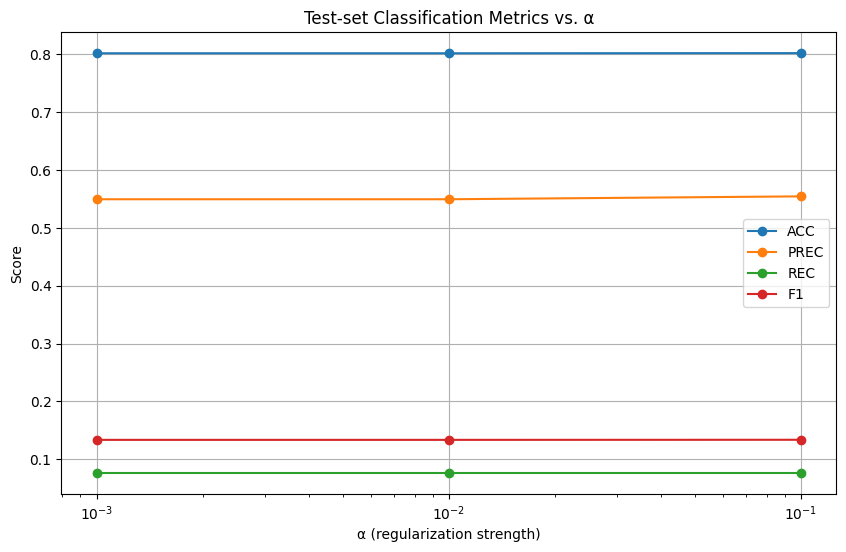

Ridge Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001     0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010     0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100     0.7951  0.7941    0.8022     0.0842  0.0824    0.0760      0.5345   
1.000     0.7951  0.7935    0.8028     0.0809  0.0770    0.0735      0.5360   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335  
0.100     0.5545    0.1455   0.1336  
1.000     0.5673    0.1405   0.1301

Best α by CV recall = 0.001



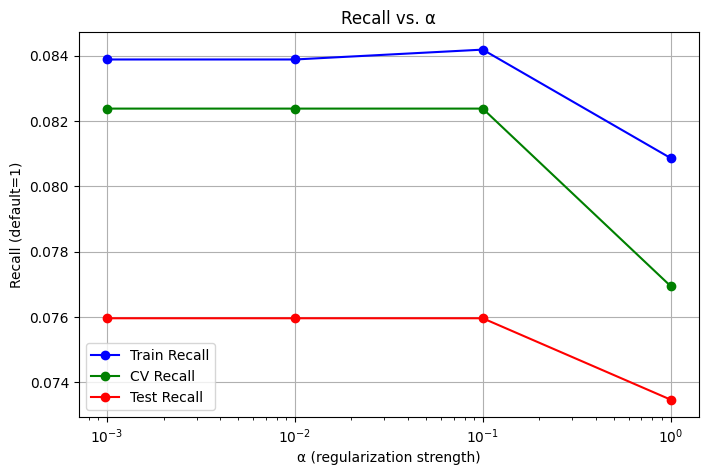

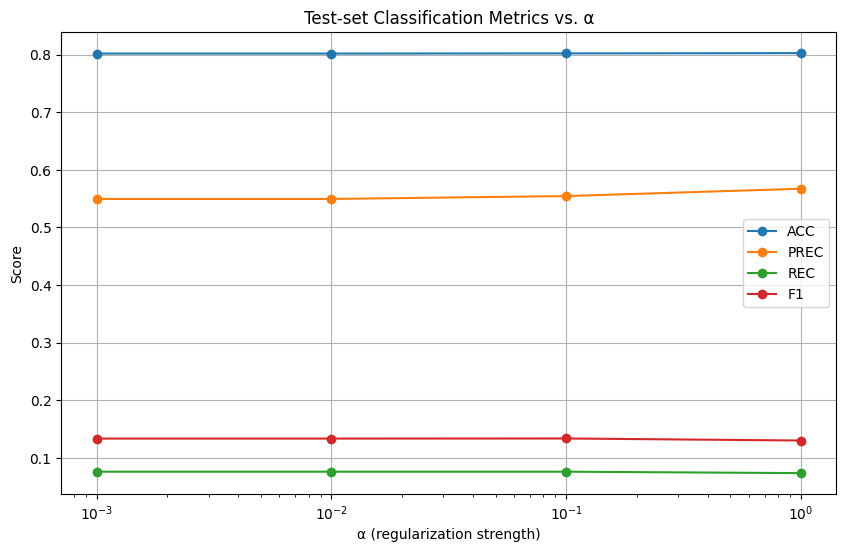

Ridge Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                          
0.001      0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010      0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100      0.7951  0.7941    0.8022     0.0842  0.0824    0.0760      0.5345   
1.000      0.7951  0.7935    0.8028     0.0809  0.0770    0.0735      0.5360   
10.000     0.7958  0.7945    0.8022     0.0703  0.0673    0.0635      0.5561   

        test_prec  train_f1  test_f1  
alpha                                 
0.001      0.5495    0.1449   0.1335  
0.010      0.5495    0.1449   0.1335  
0.100      0.5545    0.1455   0.1336  
1.000      0.5673    0.1405   0.1301  
10.000     0.5667    0.1248   0.1142

Best α by CV recall = 0.001



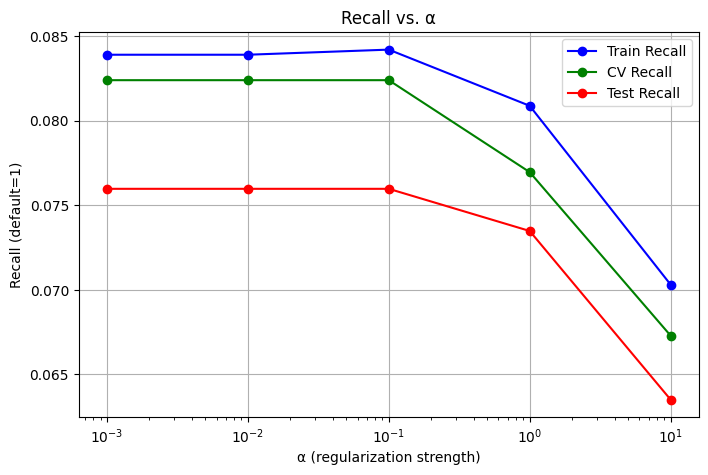

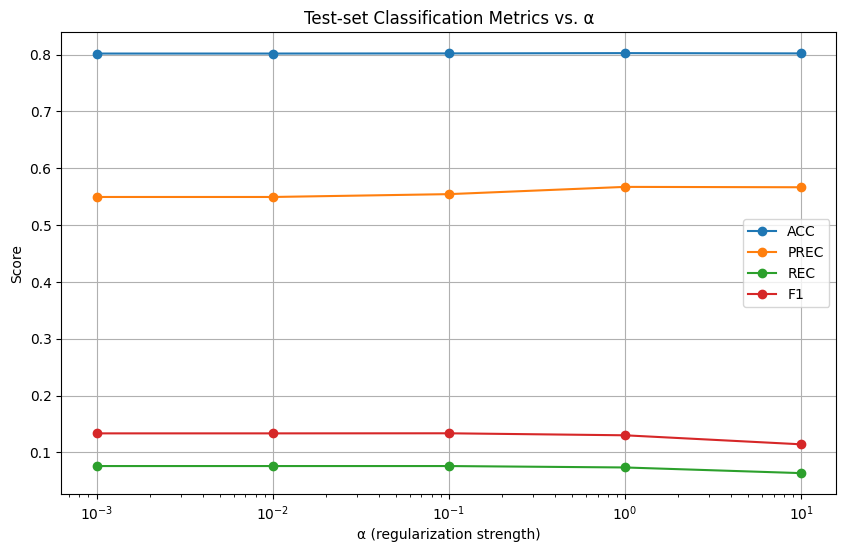

Ridge Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                           
0.001       0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010       0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100       0.7951  0.7941    0.8022     0.0842  0.0824    0.0760      0.5345   
1.000       0.7951  0.7935    0.8028     0.0809  0.0770    0.0735      0.5360   
10.000      0.7958  0.7945    0.8022     0.0703  0.0673    0.0635      0.5561   
100.000     0.7942  0.7940    0.8002     0.0287  0.0223    0.0249      0.5655   

         test_prec  train_f1  test_f1  
alpha                                  
0.001       0.5495    0.1449   0.1335  
0.010       0.5495    0.1449   0.1335  
0.100       0.5545    0.1455   0.1336  
1.000       0.5673    0.1405   0.1301  
10.000      0.5667    0.1248   0.1142  
100.000     0.5556    0.0546   0.0477

Best α by CV recall = 0.001



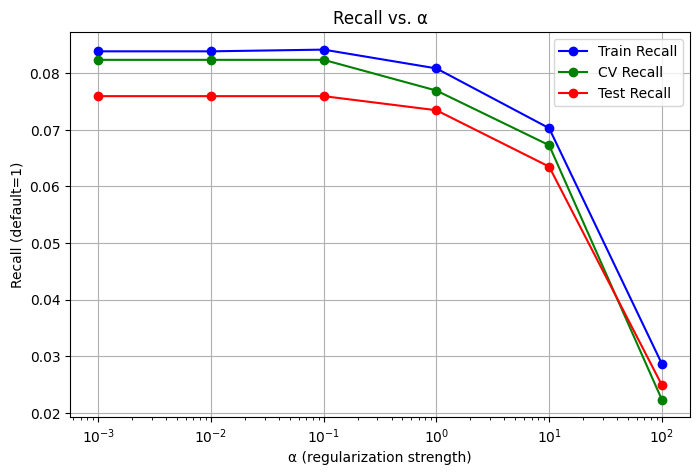

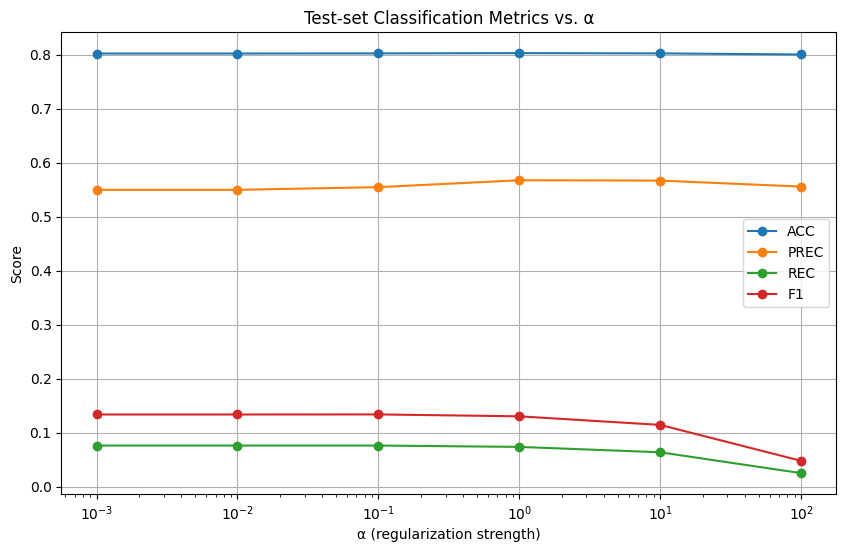

Ridge Regression Results for Different Lambda Values:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  \
alpha                                                                
0.001        0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.010        0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.100        0.7951  0.7941    0.8022     0.0842  0.0824    0.0760   
1.000        0.7951  0.7935    0.8028     0.0809  0.0770    0.0735   
10.000       0.7958  0.7945    0.8022     0.0703  0.0673    0.0635   
100.000      0.7942  0.7940    0.8002     0.0287  0.0223    0.0249   
1000.000     0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   

          train_prec  test_prec  train_f1  test_f1  
alpha                                               
0.001         0.5326     0.5495    0.1449   0.1335  
0.010         0.5326     0.5495    0.1449   0.1335  
0.100         0.5345     0.5545    0.1455   0.1336  
1.000         0.5360     0.5673    0.1405   0.1301  
10.000        0.5561     0.5667    0.1248   0.1142  
100.000       0.5655     0.5556    0.0546   0.0477  
1000.000      0.0000     0.0000    0.0000   0.0000

Best α by CV recall = 0.001



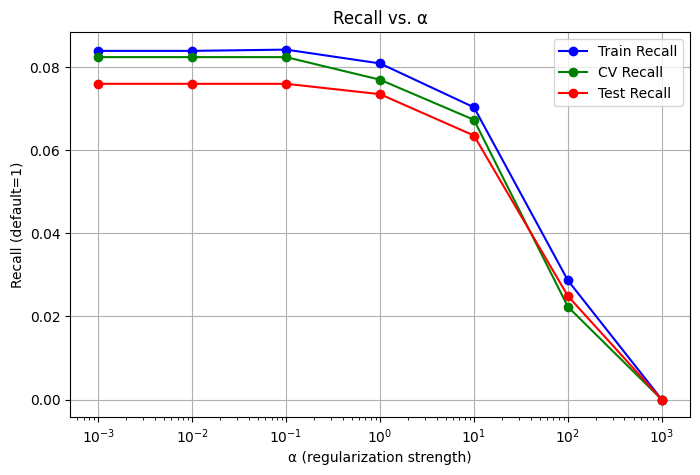

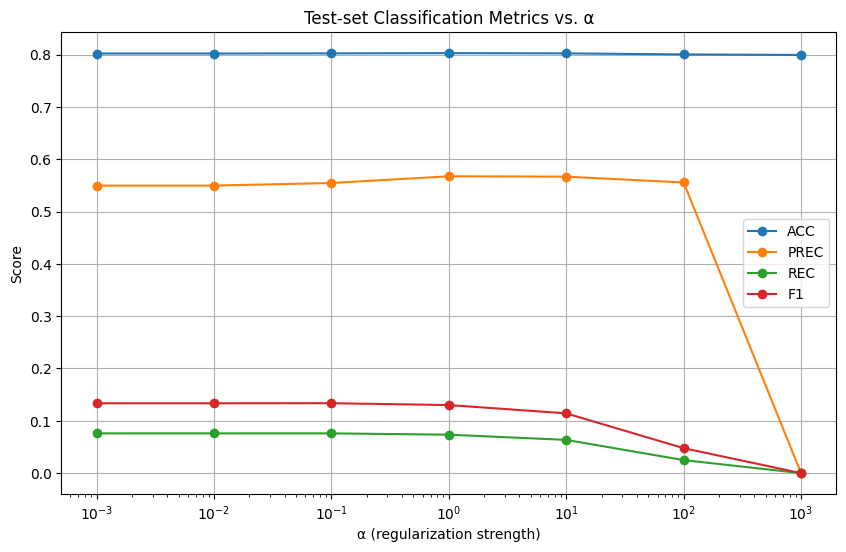

Ridge Regression Results for Different Lambda Values:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  \
alpha                                                                 
0.001         0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.010         0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.100         0.7951  0.7941    0.8022     0.0842  0.0824    0.0760   
1.000         0.7951  0.7935    0.8028     0.0809  0.0770    0.0735   
10.000        0.7958  0.7945    0.8022     0.0703  0.0673    0.0635   
100.000       0.7942  0.7940    0.8002     0.0287  0.0223    0.0249   
1000.000      0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   
10000.000     0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   

           train_prec  test_prec  train_f1  test_f1  
alpha                                                
0.001          0.5326     0.5495    0.1449   0.1335  
0.010          0.5326     0.5495    0.1449   0.1335  
0.100          0.5345     0.5545    0.1455   0.1336  
1.000          0.5360     0.5673    0.1405   0.1301  
10.000         0.5561     0.5667    0.1248   0.1142  
100.000        0.5655     0.5556    0.0546   0.0477  
1000.000       0.0000     0.0000    0.0000   0.0000  
10000.000      0.0000     0.0000    0.0000   0.0000

Best α by CV recall = 0.001



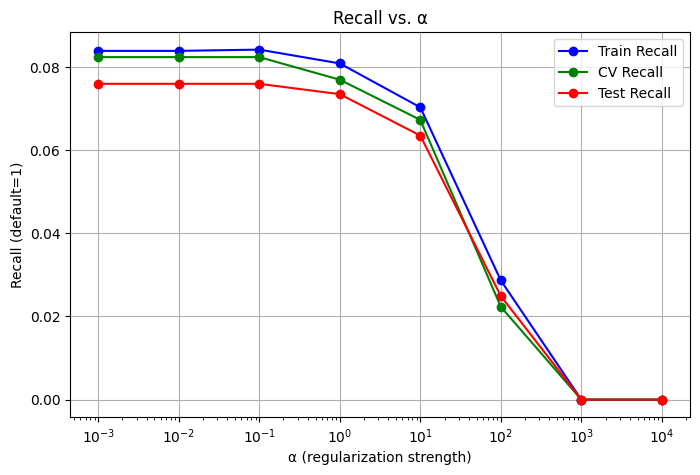

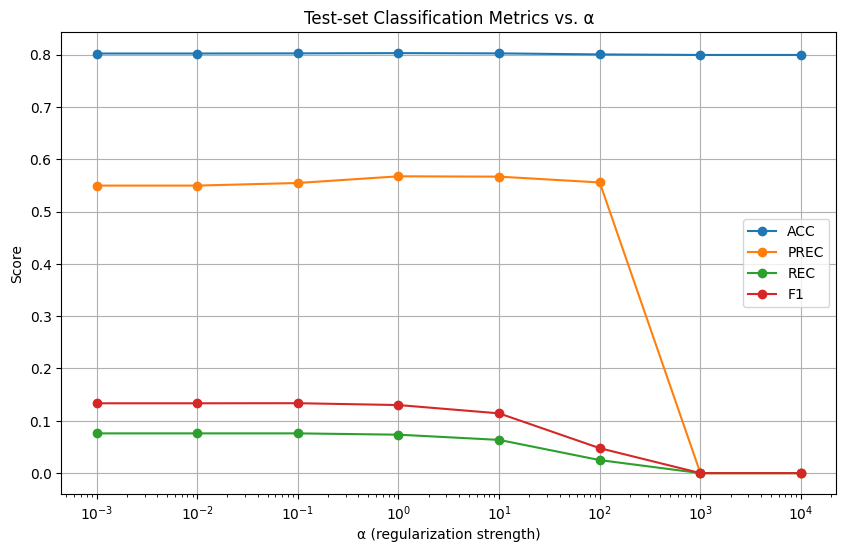

In [ ]:
def ridge_find_best_alpha(X_train, X_test, y_train, y_test, alphas):
    results = []
    for alpha in alphas:
        ridge_model = LogisticRegression(
            penalty='l2', C=1/alpha, solver='saga',
            max_iter=10000, random_state=42
        )

        # You might also want to put a print here
        # to confirm no error from model fitting.
        ridge_model.fit(X_train, y_train)

        # Evaluate
        y_train_pred = ridge_model.predict(X_train)
        y_test_pred = ridge_model.predict(X_test)

        # Cross-validation might be time-consuming; confirm it doesn’t hang.
        cv_recall = np.mean(
            cross_val_score(
                ridge_model, X_train, y_train,
                cv=5, scoring='recall'
            )
        )

        results.append({
                    'alpha': alpha,
                    # overall accuracy
                    'train_acc': accuracy_score(y_train, y_train_pred),
                    'cv_acc':    np.mean(cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='accuracy')),
                    'test_acc':  accuracy_score(y_test,  y_test_pred),

                    # recall (default class)
                    'train_rec': recall_score(y_train, y_train_pred),
                    'cv_rec':    cv_recall,
                    'test_rec':  recall_score(y_test,  y_test_pred),

                    # precision & F1
                    'train_prec': precision_score(y_train, y_train_pred),
                    'test_prec':  precision_score(y_test,  y_test_pred),
                    'train_f1':   f1_score(y_train, y_train_pred),
                    'test_f1':    f1_score(y_test,  y_test_pred),
                })

        print("Ridge Regression Results for Different Lambda Values:")
        results_df = pd.DataFrame(results).set_index('alpha').sort_index()
        display(results_df.round(4))

    #decide based on CV Recall score !
        best_alpha = results_df['cv_rec'].idxmax()
        print(f"Best α by CV recall = {best_alpha}\n")

    #score graph
        plt.figure(figsize=(8, 5))
        plt.semilogx(results_df.index, results_df['train_rec'], 'b-o', label='Train Recall')
        plt.semilogx(results_df.index, results_df['cv_rec'],    'g-o', label='CV Recall')
        plt.semilogx(results_df.index, results_df['test_rec'],  'r-o', label='Test Recall')
        plt.xlabel('α (regularization strength)')
        plt.ylabel('Recall (default=1)')
        plt.title('Recall vs. α')
        plt.legend()
        plt.grid(True)
        plt.show()

    #other metrics graph
        plt.figure(figsize=(10, 6))
        for metric in ['test_acc','test_prec','test_rec','test_f1']:
            plt.semilogx(results_df.index, results_df[metric], marker='o', label=metric.replace('test_','').upper())
        plt.xlabel('α (regularization strength)')
        plt.ylabel('Score')
        plt.title('Test‑set Classification Metrics vs. α')
        plt.legend()
        plt.grid(True)
        plt.show()

    return best_alpha

# Create a smaller data sample for quick testing (e.g., 500 rows)
X_train_sample, X_test, y_train_sample, y_test, feature_names = create_sample_test_train(
    chosen_predictors,
    n_samples=20000  # Subsample size
)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
best_alpha = ridge_find_best_alpha(X_train_sample, X_test, y_train_sample, y_test, alphas)


# Ridge: Best Alpha Model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


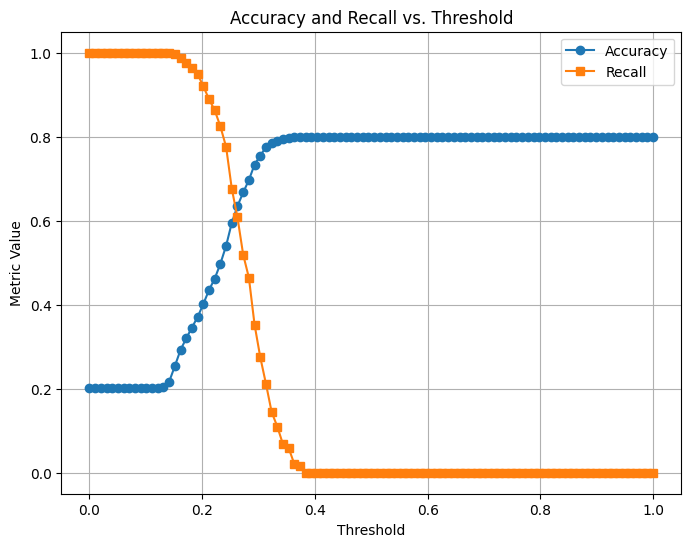

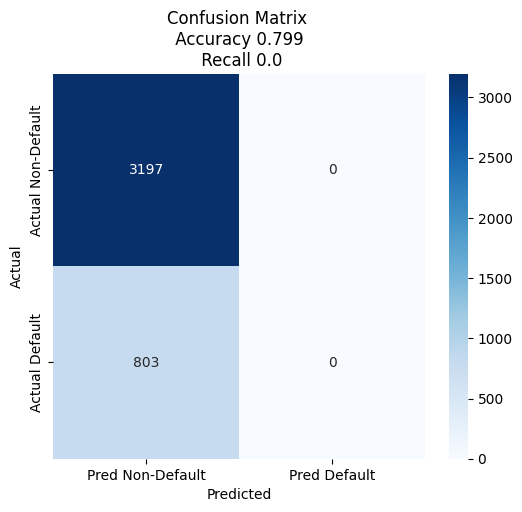

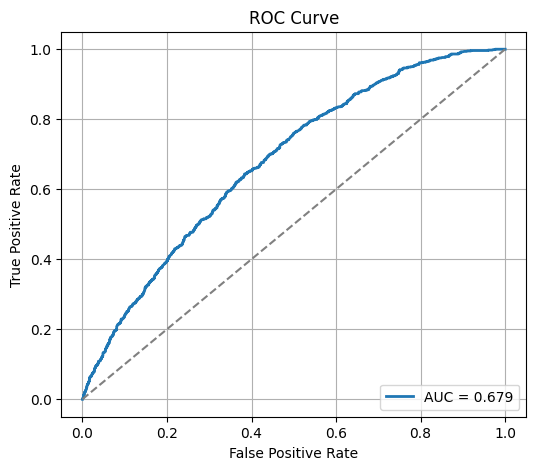

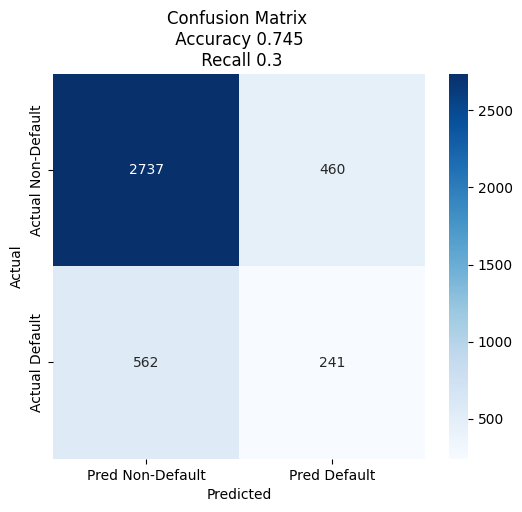

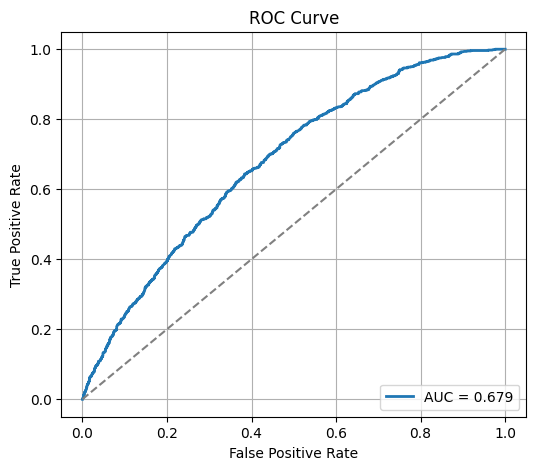

In [ ]:
best_alpha = 0.001

best_ridge_model = LogisticRegression(penalty='l2', C=1/best_alpha, solver='saga', random_state=42, max_iter=10000)  # Updated to use Ridge

y_proba, ridge_coef_df = train_test(best_ridge_model, X_train, X_test, y_train, y_test, 'ridge', feature_names)
graph_different_threshold(y_proba, y_test)

#basic threshold = 0.5
basic_threshold = 0.5
ridge_df = result_analysis(y_test, y_proba, basic_threshold, 'ridge')


#best threshold according to accuracy & recall
best_threshold = 0.3
log_best_threshold_df = result_analysis(y_test, y_proba, best_threshold, 'ridge')

# 3.4 Lasso Regression

DTI_cat_Fair: int64
DTI_cat_Good: int64
FICO_cat_Good: int64
FICO_cat_Very Good: int64
Income_cat_Low Income: int64
Income_cat_Medium Income: int64
purpose_credit_card: int64
purpose_debt_consolidation: int64
purpose_educational: int64
purpose_home_improvement: int64
purpose_house: int64
purpose_major_purchase: int64
purpose_medical: int64
purpose_moving: int64
purpose_other: int64
purpose_renewable_energy: int64
purpose_small_business: int64
purpose_vacation: int64
purpose_wedding: int64
home_ownership_MORTGAGE: int64
home_ownership_NONE: int64
home_ownership_OWN: int64
home_ownership_RENT: int64
term_ 60 months: int64
loan_amnt_cat_medium: int64
loan_amnt_cat_small: int64
verification_status_Source Verified: int64
verification_status_Verified: int64
grade_B: int64
grade_C: int64
grade_D: int64
grade_E: int64
grade_F: int64
grade_G: int64
emp_length_cat_Mid: int64
emp_length_cat_Newbie: int64
emp_length_cat_Senior: int64
Predictors: ['DTI_cat_Fair', 'DTI_cat_Good', 'FICO_cat_Good', 'F

train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335

Best α by CV recall = 0.001



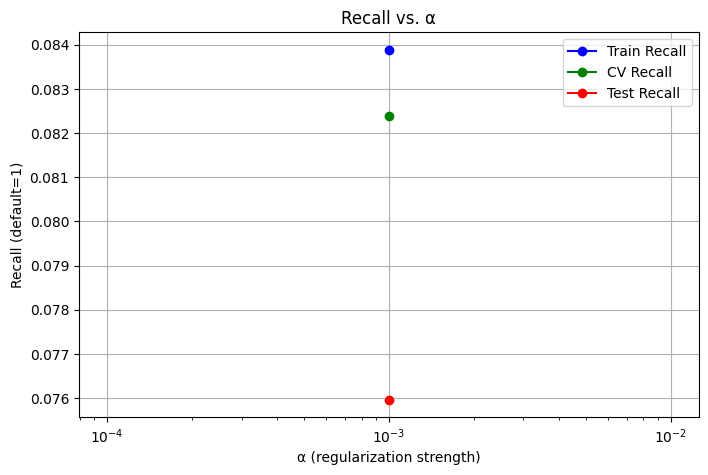

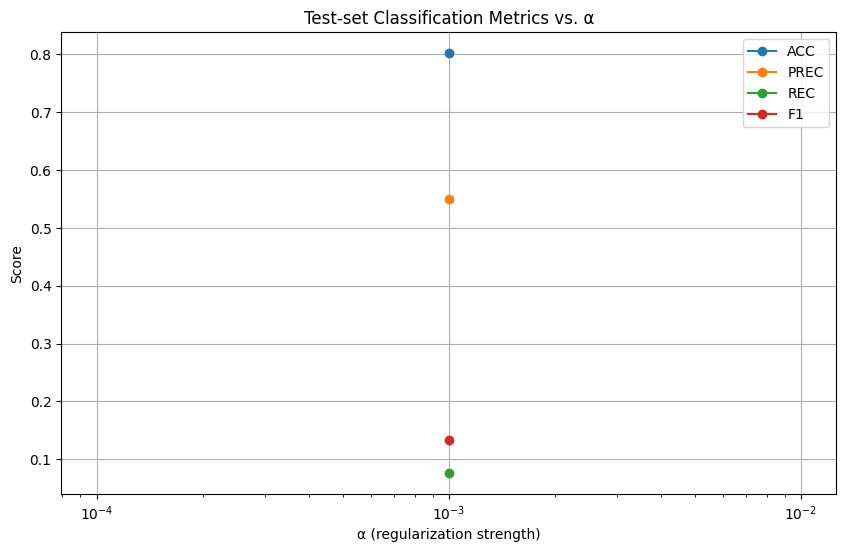

Lasso Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   
0.010      0.795   0.794     0.802     0.0839  0.0824     0.076      0.5326   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335

Best α by CV recall = 0.001



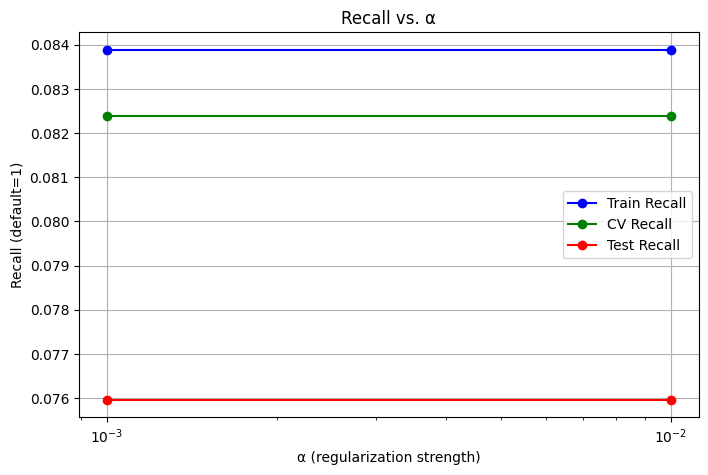

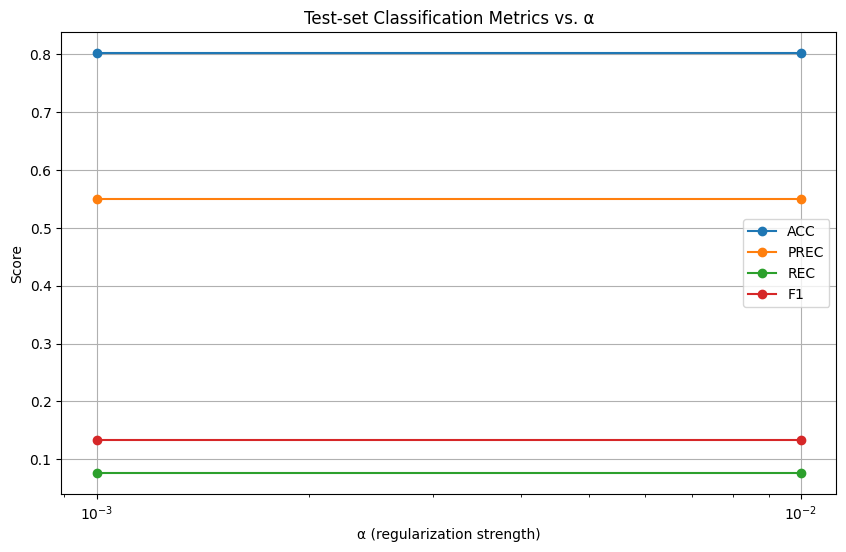

Lasso Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795  0.7940    0.8020     0.0839  0.0824     0.076      0.5326   
0.010      0.795  0.7940    0.8020     0.0839  0.0824     0.076      0.5326   
0.100      0.795  0.7941    0.8025     0.0839  0.0824     0.076      0.5326   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335  
0.100     0.5596    0.1449   0.1338

Best α by CV recall = 0.001



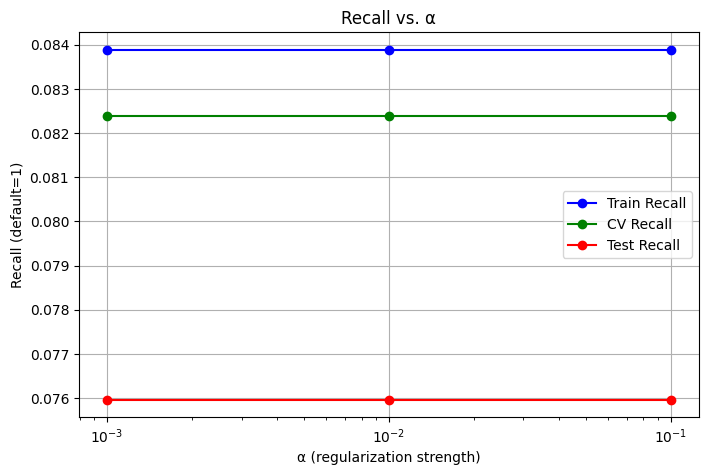

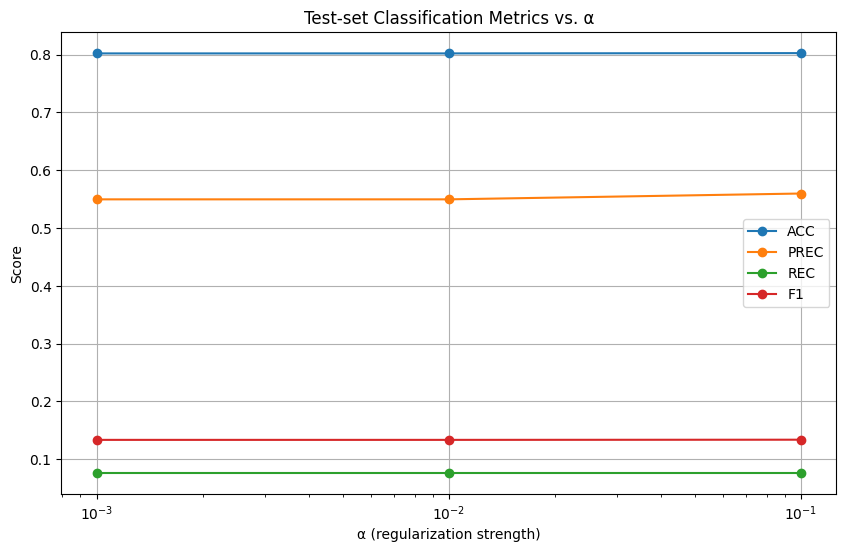

Lasso Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                         
0.001      0.795  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010      0.795  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100      0.795  0.7941    0.8025     0.0839  0.0824    0.0760      0.5326   
1.000      0.795  0.7941    0.8032     0.0809  0.0797    0.0735      0.5339   

       test_prec  train_f1  test_f1  
alpha                                
0.001     0.5495    0.1449   0.1335  
0.010     0.5495    0.1449   0.1335  
0.100     0.5596    0.1449   0.1338  
1.000     0.5784    0.1405   0.1304

Best α by CV recall = 0.001



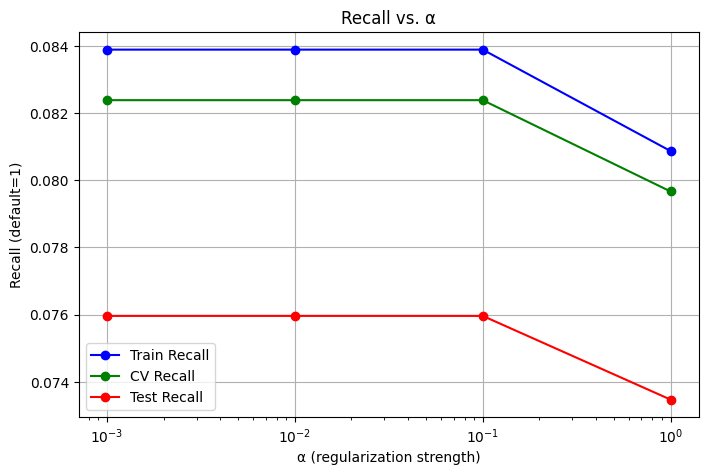

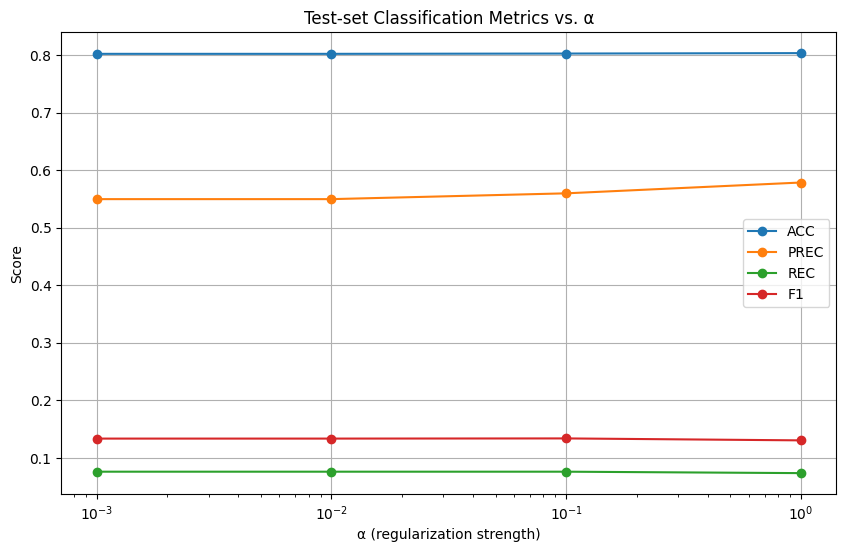

Lasso Regression Results for Different Lambda Values:


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                          
0.001      0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010      0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100      0.7950  0.7941    0.8025     0.0839  0.0824    0.0760      0.5326   
1.000      0.7950  0.7941    0.8032     0.0809  0.0797    0.0735      0.5339   
10.000     0.7958  0.7946    0.8035     0.0694  0.0640    0.0610      0.5556   

        test_prec  train_f1  test_f1  
alpha                                 
0.001      0.5495    0.1449   0.1335  
0.010      0.5495    0.1449   0.1335  
0.100      0.5596    0.1449   0.1338  
1.000      0.5784    0.1405   0.1304  
10.000     0.6049    0.1234   0.1109

Best α by CV recall = 0.001



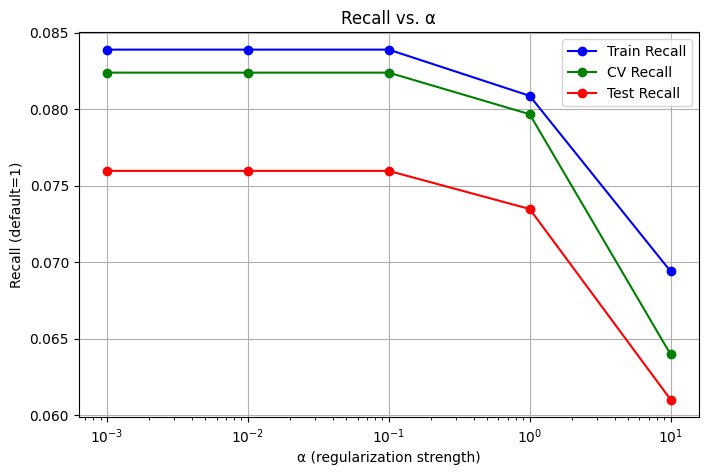

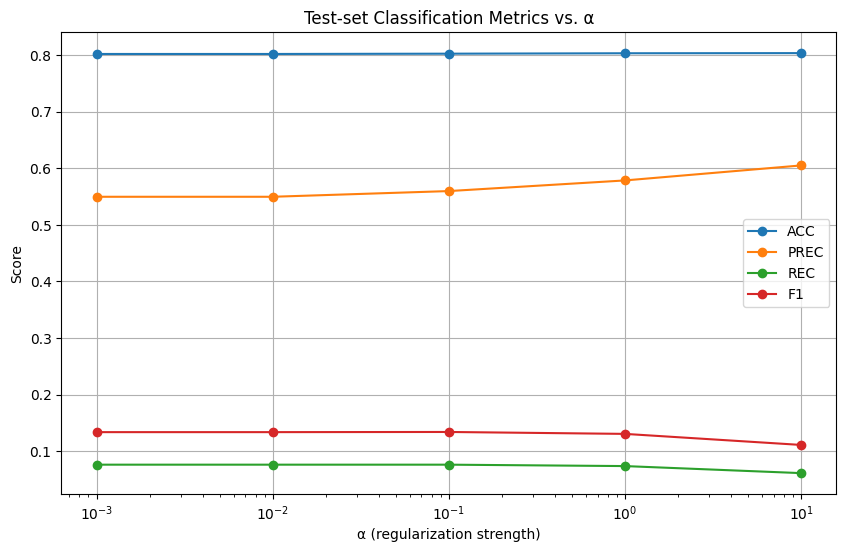

Lasso Regression Results for Different Lambda Values:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  train_prec  \
alpha                                                                           
0.001       0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.010       0.7950  0.7940    0.8020     0.0839  0.0824    0.0760      0.5326   
0.100       0.7950  0.7941    0.8025     0.0839  0.0824    0.0760      0.5326   
1.000       0.7950  0.7941    0.8032     0.0809  0.0797    0.0735      0.5339   
10.000      0.7958  0.7946    0.8035     0.0694  0.0640    0.0610      0.5556   
100.000     0.7929  0.7929    0.7992     0.0000  0.0000    0.0000      0.0000   

         test_prec  train_f1  test_f1  
alpha                                  
0.001       0.5495    0.1449   0.1335  
0.010       0.5495    0.1449   0.1335  
0.100       0.5596    0.1449   0.1338  
1.000       0.5784    0.1405   0.1304  
10.000      0.6049    0.1234   0.1109  
100.000     0.0000    0.0000   0.0000

Best α by CV recall = 0.001



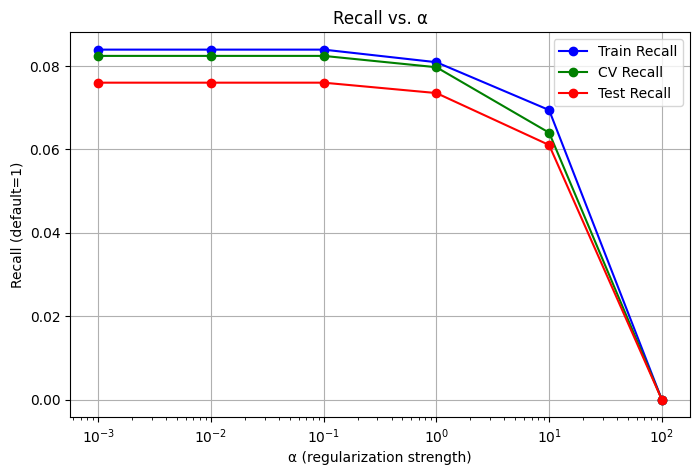

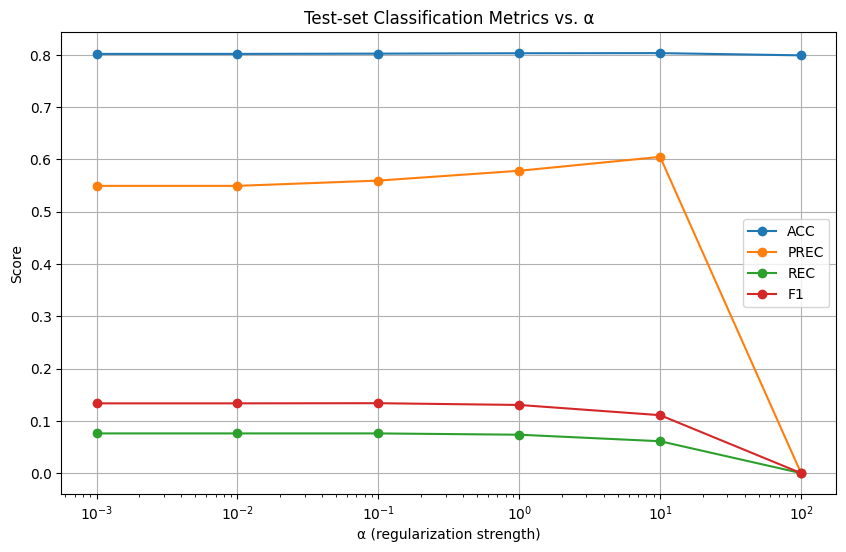

Lasso Regression Results for Different Lambda Values:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  \
alpha                                                                
0.001        0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.010        0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.100        0.7950  0.7941    0.8025     0.0839  0.0824    0.0760   
1.000        0.7950  0.7941    0.8032     0.0809  0.0797    0.0735   
10.000       0.7958  0.7946    0.8035     0.0694  0.0640    0.0610   
100.000      0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   
1000.000     0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   

          train_prec  test_prec  train_f1  test_f1  
alpha                                               
0.001         0.5326     0.5495    0.1449   0.1335  
0.010         0.5326     0.5495    0.1449   0.1335  
0.100         0.5326     0.5596    0.1449   0.1338  
1.000         0.5339     0.5784    0.1405   0.1304  
10.000        0.5556     0.6049    0.1234   0.1109  
100.000       0.0000     0.0000    0.0000   0.0000  
1000.000      0.0000     0.0000    0.0000   0.0000

Best α by CV recall = 0.001



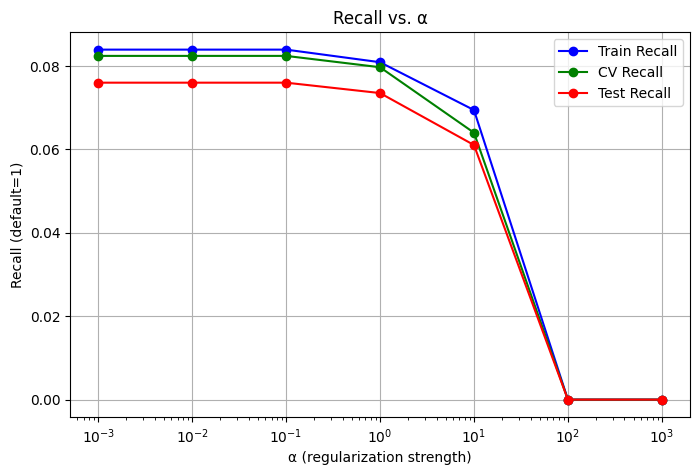

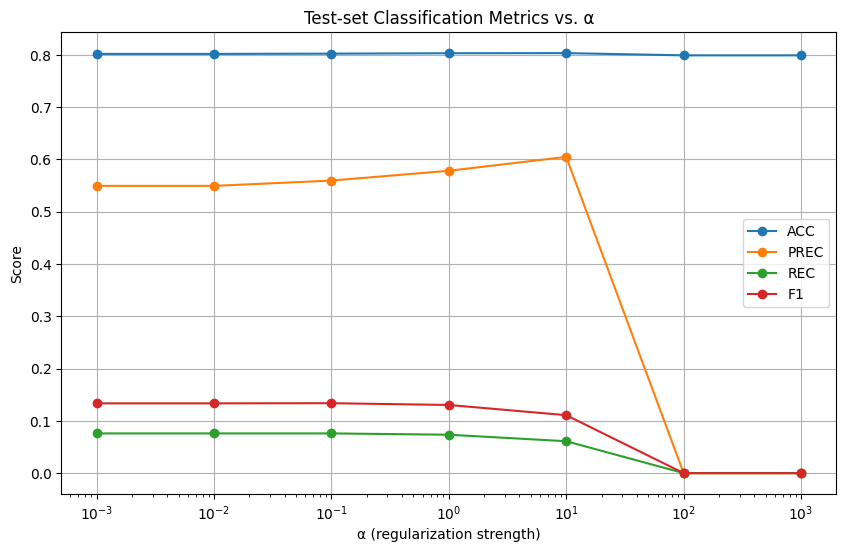

Lasso Regression Results for Different Lambda Values:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train_acc  cv_acc  test_acc  train_rec  cv_rec  test_rec  \
alpha                                                                 
0.001         0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.010         0.7950  0.7940    0.8020     0.0839  0.0824    0.0760   
0.100         0.7950  0.7941    0.8025     0.0839  0.0824    0.0760   
1.000         0.7950  0.7941    0.8032     0.0809  0.0797    0.0735   
10.000        0.7958  0.7946    0.8035     0.0694  0.0640    0.0610   
100.000       0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   
1000.000      0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   
10000.000     0.7929  0.7929    0.7992     0.0000  0.0000    0.0000   

           train_prec  test_prec  train_f1  test_f1  
alpha                                                
0.001          0.5326     0.5495    0.1449   0.1335  
0.010          0.5326     0.5495    0.1449   0.1335  
0.100          0.5326     0.5596    0.1449   0.1338  
1.000          0.5339     0.5784    0.1405   0.1304  
10.000         0.5556     0.6049    0.1234   0.1109  
100.000        0.0000     0.0000    0.0000   0.0000  
1000.000       0.0000     0.0000    0.0000   0.0000  
10000.000      0.0000     0.0000    0.0000   0.0000

Best α by CV recall = 0.001



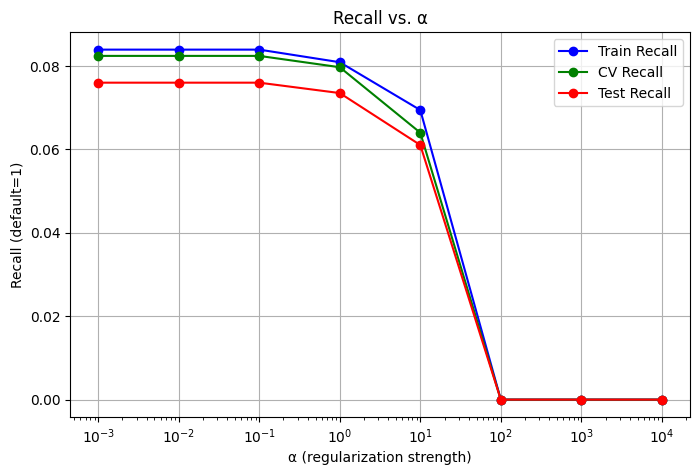

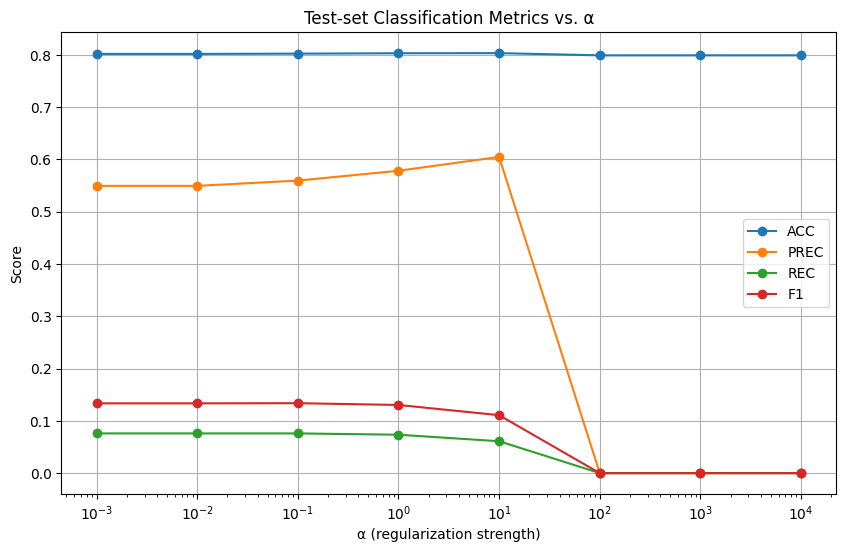

In [ ]:
def lasso_find_best_alpha(X_train, X_test, y_train, y_test, alphas):
    results = []
    for alpha in alphas:
        lasso_model = LogisticRegression(
            penalty='l1', C=1/alpha, solver='saga',
            max_iter=10000, random_state=42
        )

        # You might also want to put a print here
        # to confirm no error from model fitting.
        lasso_model.fit(X_train, y_train)

        # Evaluate
        y_train_pred = lasso_model.predict(X_train)
        y_test_pred = lasso_model.predict(X_test)

        # Cross-validation might be time-consuming; confirm it doesn’t hang.
        cv_recall = np.mean(
            cross_val_score(
                lasso_model, X_train, y_train,
                cv=5, scoring='recall'
            )
        )

        results.append({
                    'alpha': alpha,
                    # overall accuracy
                    'train_acc': accuracy_score(y_train, y_train_pred),
                    'cv_acc':    np.mean(cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='accuracy')),
                    'test_acc':  accuracy_score(y_test,  y_test_pred),

                    # recall (default class)
                    'train_rec': recall_score(y_train, y_train_pred),
                    'cv_rec':    cv_recall,
                    'test_rec':  recall_score(y_test,  y_test_pred),

                    # precision & F1
                    'train_prec': precision_score(y_train, y_train_pred),
                    'test_prec':  precision_score(y_test,  y_test_pred),
                    'train_f1':   f1_score(y_train, y_train_pred),
                    'test_f1':    f1_score(y_test,  y_test_pred),
                })

        print("Lasso Regression Results for Different Lambda Values:")
        results_df = pd.DataFrame(results).set_index('alpha').sort_index()
        display(results_df.round(4))

    #decide based on CV Recall score !
        best_alpha = results_df['cv_rec'].idxmax()
        print(f"Best α by CV recall = {best_alpha}\n")

    #score graph
        plt.figure(figsize=(8, 5))
        plt.semilogx(results_df.index, results_df['train_rec'], 'b-o', label='Train Recall')
        plt.semilogx(results_df.index, results_df['cv_rec'],    'g-o', label='CV Recall')
        plt.semilogx(results_df.index, results_df['test_rec'],  'r-o', label='Test Recall')
        plt.xlabel('α (regularization strength)')
        plt.ylabel('Recall (default=1)')
        plt.title('Recall vs. α')
        plt.legend()
        plt.grid(True)
        plt.show()

    #other metrics graph
        plt.figure(figsize=(10, 6))
        for metric in ['test_acc','test_prec','test_rec','test_f1']:
            plt.semilogx(results_df.index, results_df[metric], marker='o', label=metric.replace('test_','').upper())
        plt.xlabel('α (regularization strength)')
        plt.ylabel('Score')
        plt.title('Test‑set Classification Metrics vs. α')
        plt.legend()
        plt.grid(True)
        plt.show()

    return best_alpha

# Create a smaller data sample for quick testing (e.g., 500 rows)
X_train_sample, X_test, y_train_sample, y_test, feature_names = create_sample_test_train(
    chosen_predictors,
    n_samples=20000  # Subsample size
)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
best_alpha = lasso_find_best_alpha(X_train_sample, X_test, y_train_sample, y_test, alphas)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


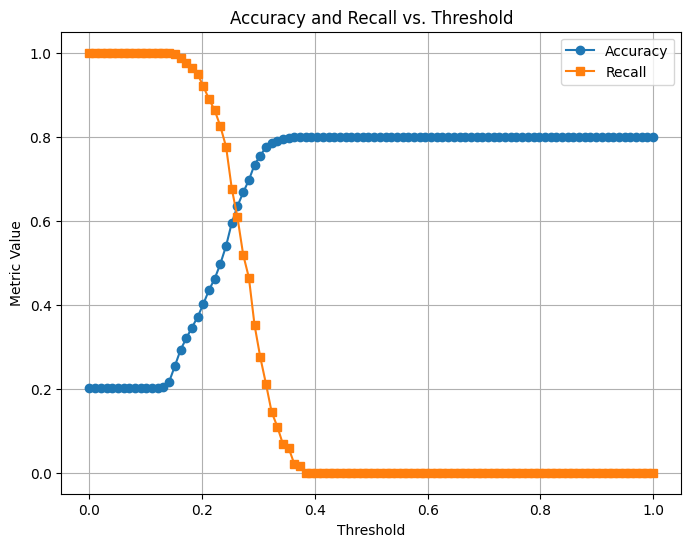

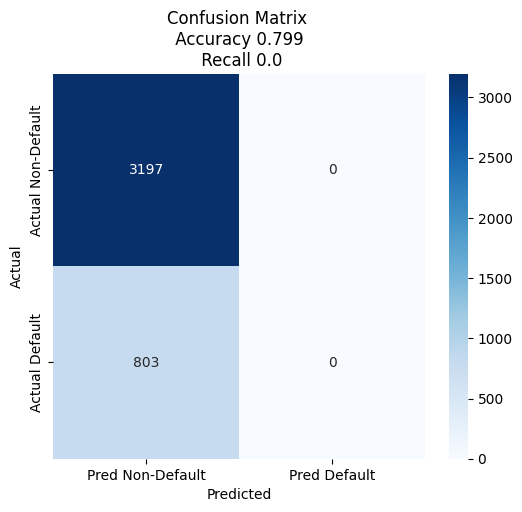

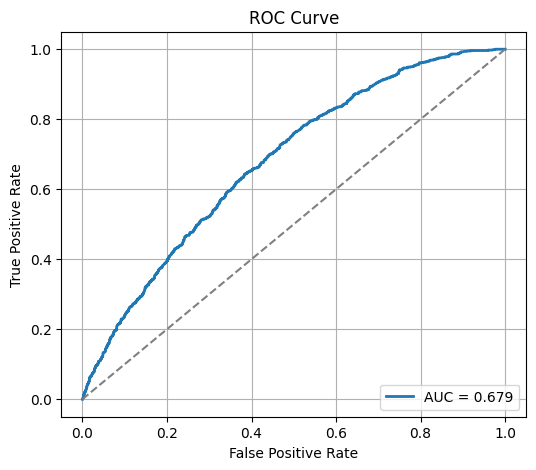

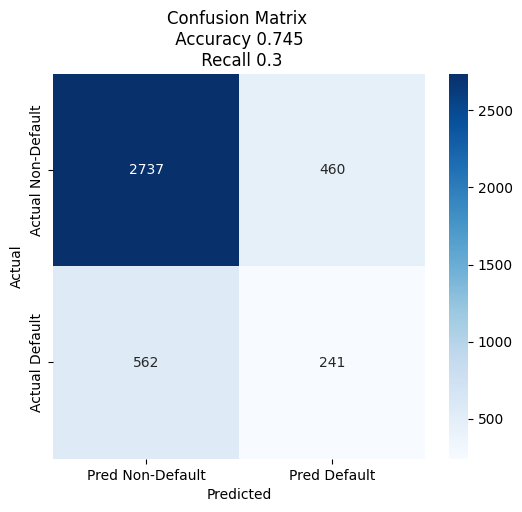

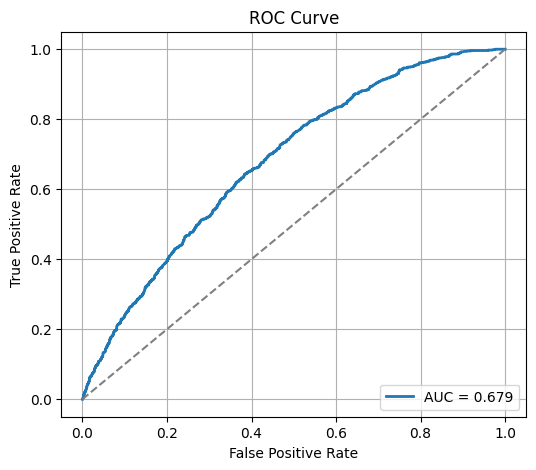

In [ ]:
best_alpha = 0.001

best_ridge_model = LogisticRegression(penalty='l1', C=1/best_alpha, solver='saga', random_state=42, max_iter=10000)  # Updated to use Ridge

y_proba, ridge_coef_df = train_test(best_ridge_model, X_train, X_test, y_train, y_test, 'lasso', feature_names)
graph_different_threshold(y_proba, y_test)

#basic threshold = 0.5
basic_threshold = 0.5
ridge_df = result_analysis(y_test, y_proba, basic_threshold, 'lasso')


#best threshold according to accuracy & recall
best_threshold = 0.3
log_best_threshold_df = result_analysis(y_test, y_proba, best_threshold, 'lasso')

# Be Creative

Cross-validation ROC AUC scores: [0.68005878 0.67678252 0.6785933  0.68099326 0.67688748]
Mean ROC AUC score: 0.6786630688270832


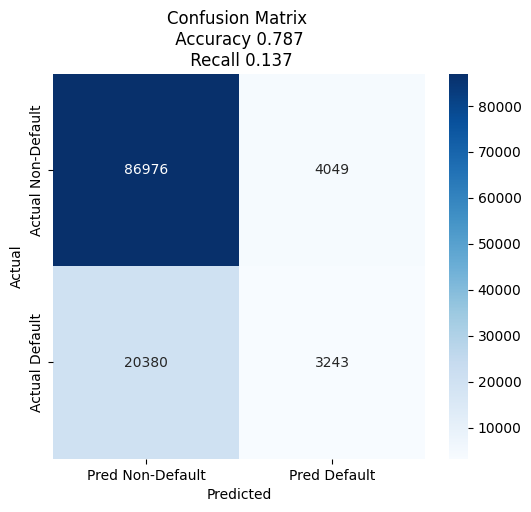

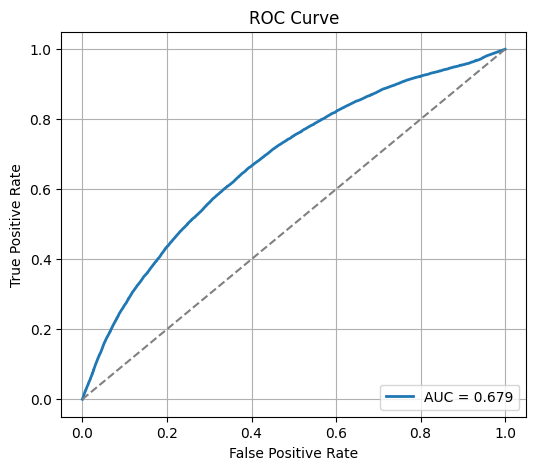

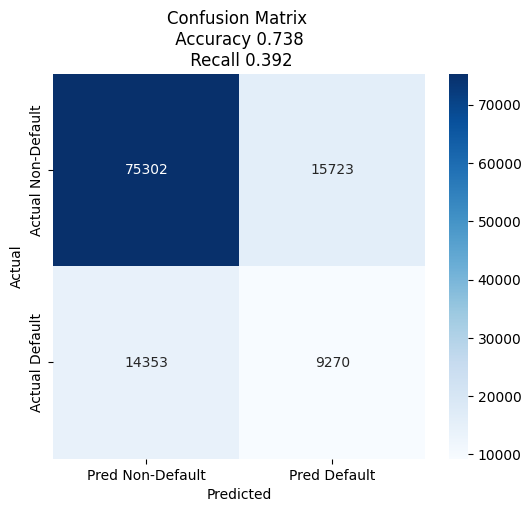

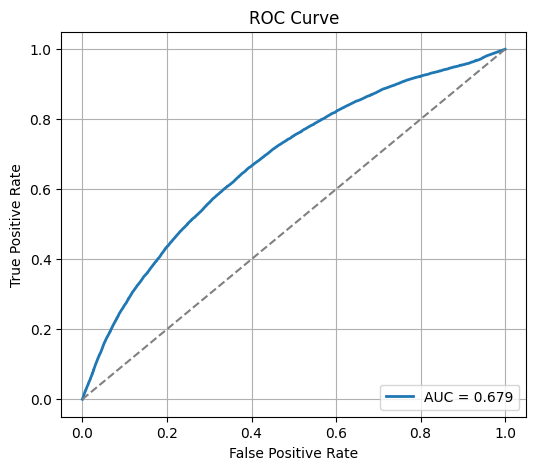

In [ ]:
# prompt: I want to use random forest to predict the loan default rate, and also show the metrics

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# ... (Your existing code) ...

# 3.5 Random Forest
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict probabilities for the test set
y_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean ROC AUC score: {np.mean(cv_scores)}")


#basic threshold = 0.5
basic_threshold = 0.5
rf_df = result_analysis(y_test, y_proba_rf, basic_threshold, 'random_forest')

#best threshold according to accuracy & recall
best_threshold = 0.3
rf_best_threshold_df = result_analysis(y_test, y_proba_rf, best_threshold, 'random_forest')


# Model Comparison

In [ ]:
# prompt: I need a table that put all the regressions metrics result for better comparison, one for when the threshold is 0.5, one for when the threshold is 0.3, give me 2 separated table

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Concatenate all results dataframes
results_05 = pd.concat([ols_df, log_df, ridge_df, rf_df])
results_03 = pd.concat([ols_best_threshold_df, log_best_threshold_df, log_best_threshold_df, rf_best_threshold_df])


# Display the tables
print("Regression Metrics (Threshold = 0.5)")
display(results_05)

print("\nRegression Metrics (Threshold = 0.3)")
display(results_03)


Regression Metrics (Threshold = 0.5)


Model Type  Accuracy  Precision    Recall  F1-Score       AOC
0            ols  0.796900   0.563918  0.063116  0.113526  0.714577
0       logistic  0.797319   0.550816  0.088558  0.152584  0.715414
0          lasso  0.799250   0.000000  0.000000  0.000000  0.678836
0  random_forest  0.786922   0.444734  0.137281  0.209801  0.678909


Regression Metrics (Threshold = 0.3)


Model Type  Accuracy  Precision    Recall  F1-Score       AOC
0            ols  0.748884   0.399298  0.433645  0.415764  0.714577
0          lasso  0.744500   0.343795  0.300125  0.320479  0.678836
0          lasso  0.744500   0.343795  0.300125  0.320479  0.678836
0  random_forest  0.737667   0.370904  0.392414  0.381356  0.678909